# Triplets Final Analysis

Goal: A clean version of the triplets analysis for the paper

## Setup

In [1]:
# Import modules and R
import numpy as np, pandas as pd
import pickle
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Import local code
import sys
sys.path.append('../code')
from processing_helpers import *
from analysis_helpers import *
from triplets import *
from pcaVersion import *
from gradientVersion import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");

## Triplets 

In [3]:
# triplets_hcp = get_triplets(atlas=fetch_hcp())
# save_pickle(triplets_hcp, "triplets_hcp")
triplets_hcp = load_pickle('triplets_hcp')
print("Got base triplets")
# triplets_hcp_3donors = get_triplets(atlas=fetch_hcp(), donors_threshold=3)
# save_pickle(triplets_hcp_3donors, "triplets_hcp_3donors")
triplets_hcp_3donors = load_pickle('triplets_hcp_3donors')
print("Got 3donors triplets")

# triplets_hcp_2donors = get_triplets(atlas=fetch_hcp(), donors_threshold=2)
# save_pickle(triplets_hcp_2donors, "triplets_hcp_2donors")
triplets_hcp_2donors = load_pickle('triplets_hcp_2donors')
print("Got 2donors triplets")

Got base triplets
Got 3donors triplets
Got 2donors triplets


## 1. PCA triplets — no scaling

In [101]:
triplet_versions_dict = {
    'No filters': triplets_hcp,
    'Region filter \n(3+ donors)': triplets_hcp_3donors,
    'Gene filter \n(top 20% diff. stab.)': filter_triplet_ds(triplets_hcp, 0.8),
    'Both region \n& gene filters': filter_triplet_ds(triplets_hcp_3donors, 0.8)
}

triplet_versions = make_triplet_versions_plot(triplet_versions_dict)

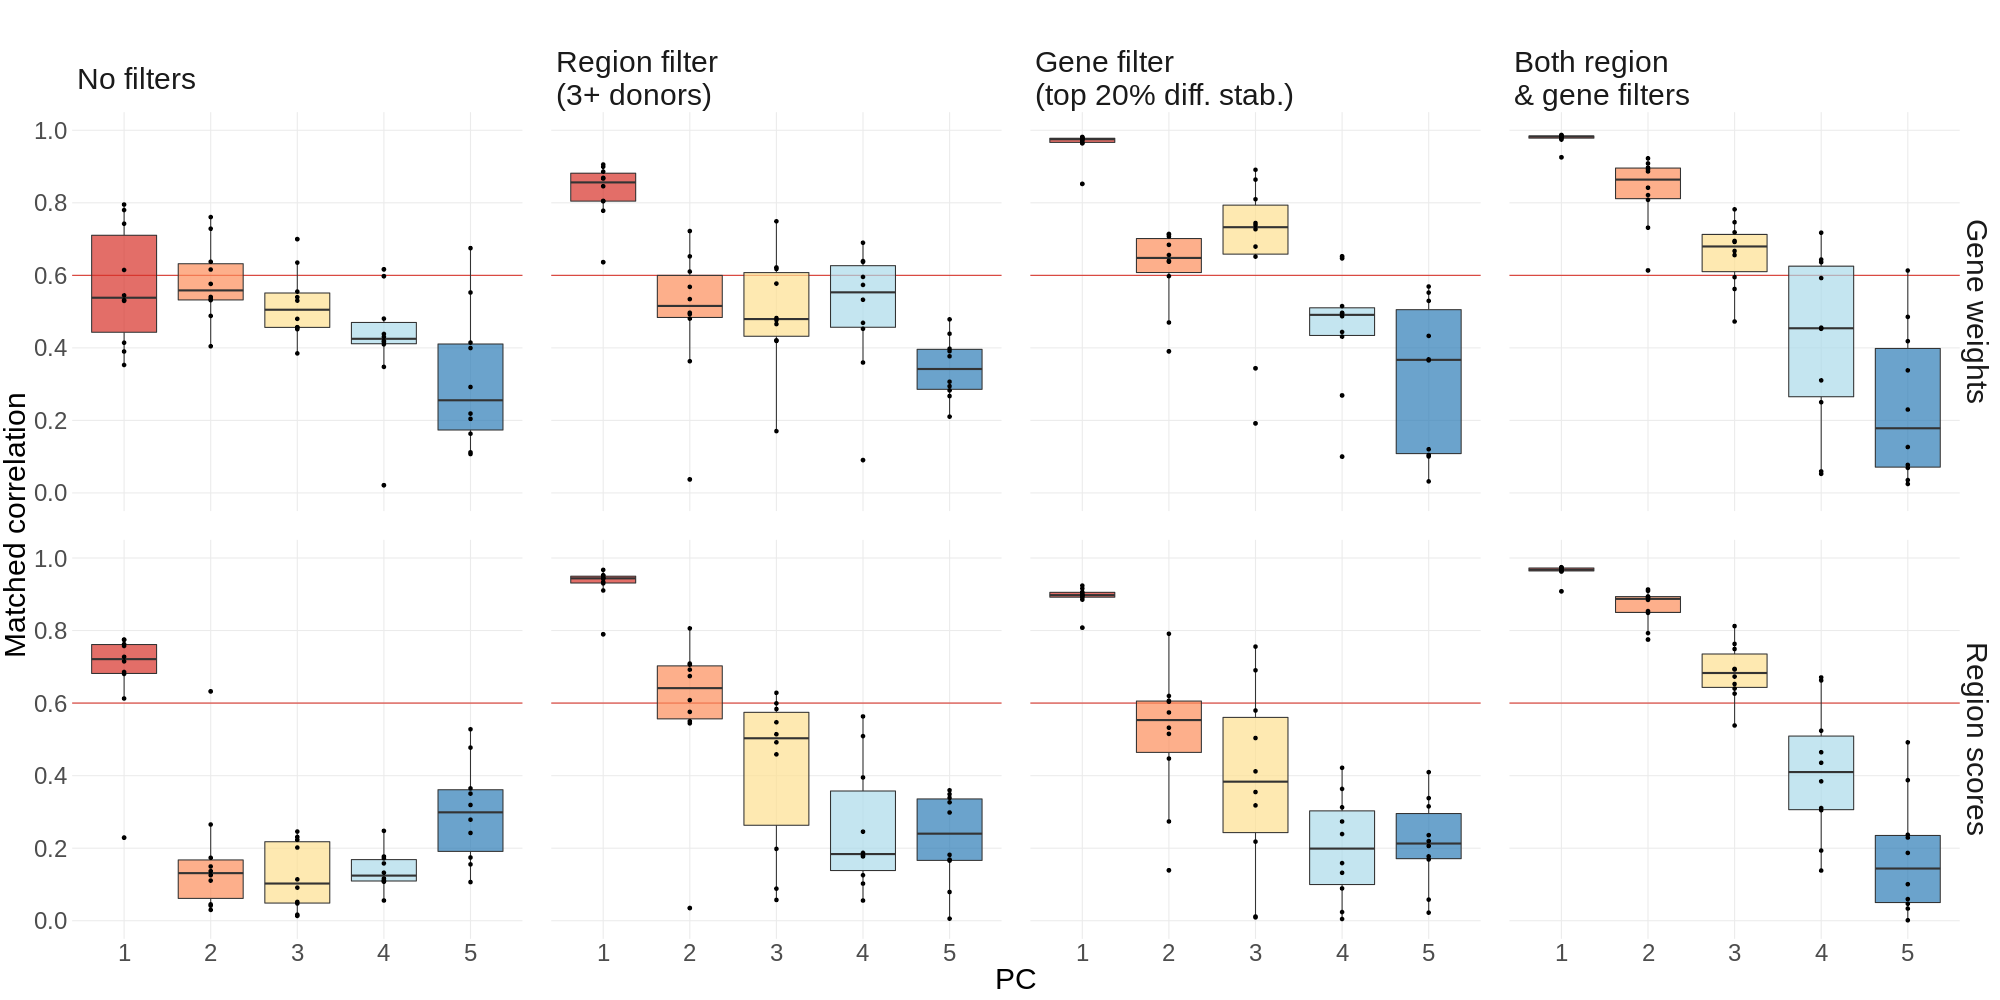

In [102]:
%%R -w 2000 -h 1000 -i triplet_versions
plot_triplets(triplet_versions) & theme(text=element_text(size=30))

## 1a PCA triplets — with scaling

In [53]:
triplet_versions_dict = {
    'No filters': filter_triplet_ds(triplets_hcp, ds_threshold=0, scale=True),
    'Region filter \n(3+ donors)': filter_triplet_ds(triplets_hcp_3donors, ds_threshold=0, scale=True),
    'Gene filter \n(top 20% diff. stab.)': filter_triplet_ds(triplets_hcp, ds_threshold=0.8, scale=True),
    'Both region \n& gene filters': filter_triplet_ds(triplets_hcp_3donors, ds_threshold=0.8, scale=True)
}

triplet_versions = make_triplet_versions_plot(triplet_versions_dict)

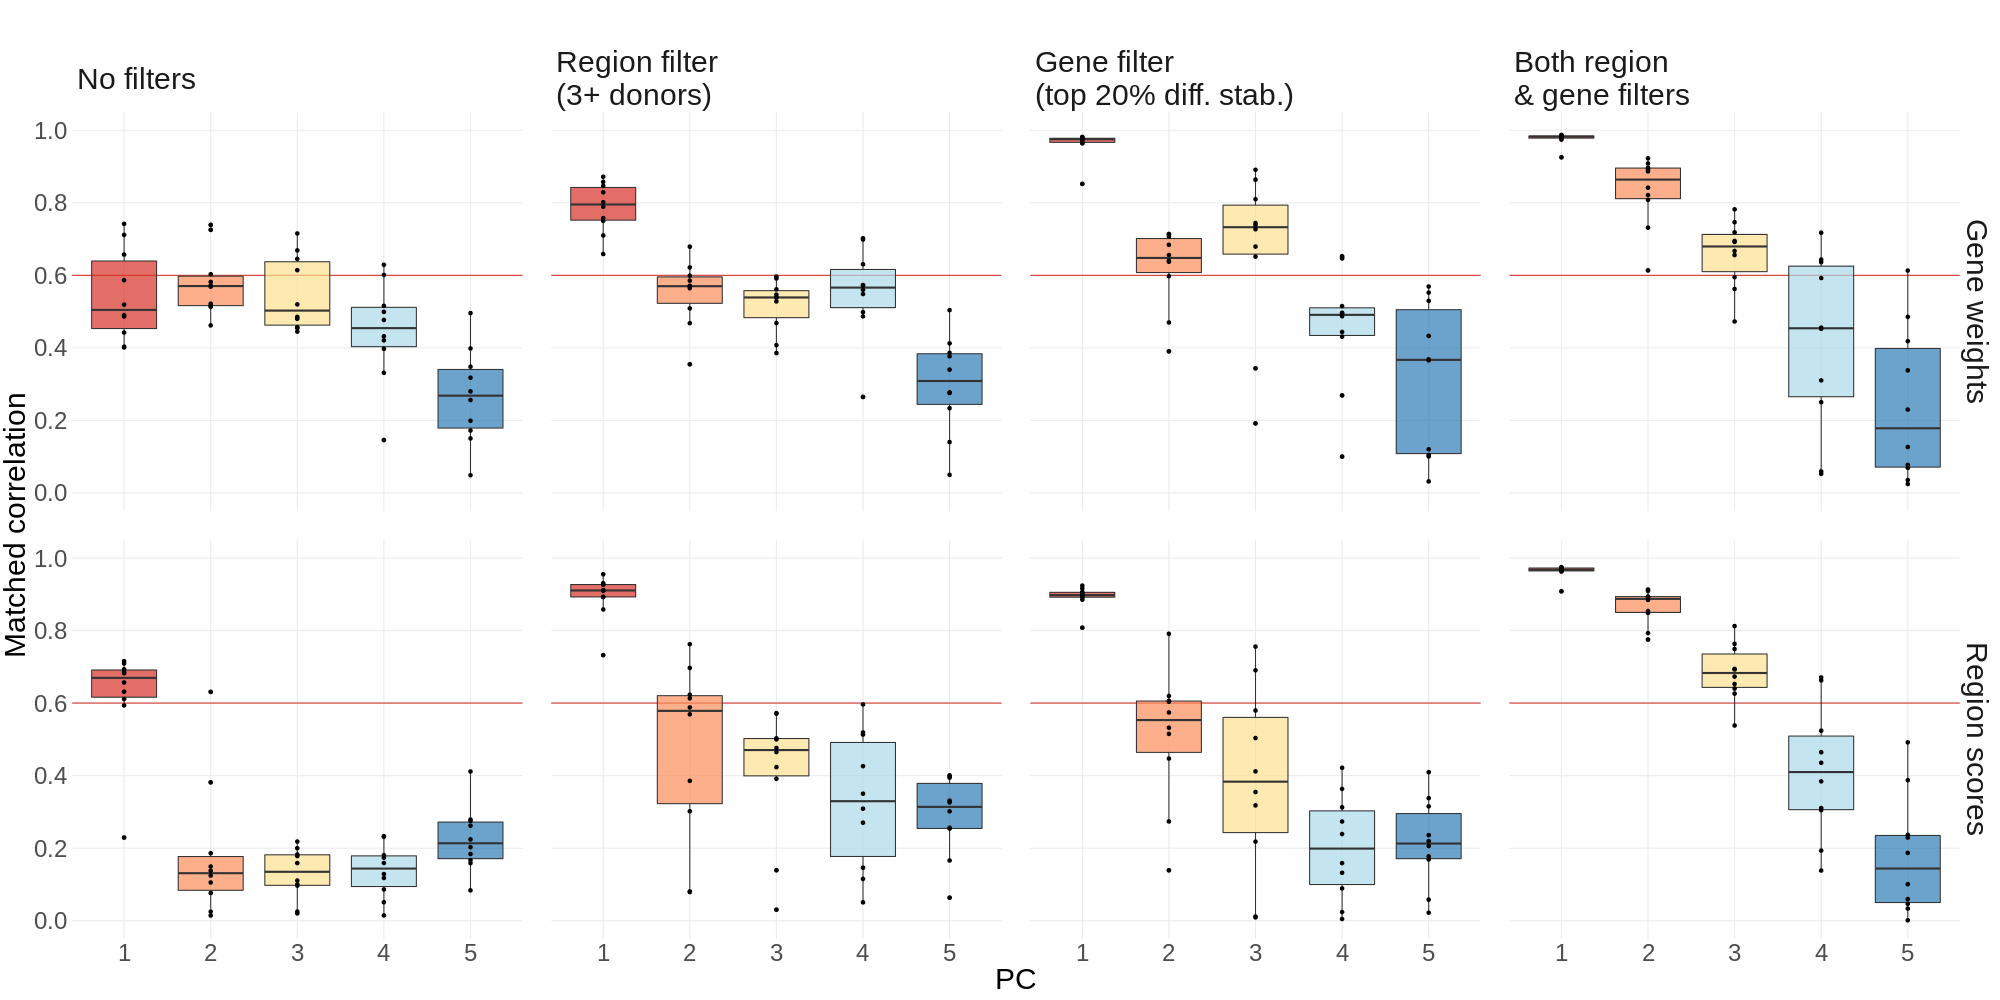

In [54]:
%%R -w 2000 -h 1000 -i triplet_versions
plot_triplets(triplet_versions) & theme(text=element_text(size=30))

Looks identical with and without scaling. Let's confirm if it is:

In [64]:
no_scale = filter_triplet_ds(triplets_hcp_3donors, ds_threshold=0.8, scale=False)
with_scale = filter_triplet_ds(triplets_hcp_3donors, ds_threshold=0.8, scale=True)
no_scale['012'].corr_scores(with_scale['012'])

0         1         2         3         4
0  0.999766  0.015222 -0.008296 -0.000974 -0.007846
1 -0.015199  0.998808 -0.029991 -0.003208 -0.001652
2  0.008126  0.029701  0.997767 -0.039330  0.023997
3  0.000500  0.004220  0.041403  0.994062 -0.095979
4  0.007489  0.001995 -0.020630  0.096574  0.991294

## 2 Diffusion mapping

With DM triplets we only have scores, no coefs

In [147]:
triplet_versions_dict = {
    'No filters': filter_triplet_ds(triplets_hcp, ds_threshold=0, use_gradientVersion=True, approach='dm', kernel='gaussian'),
    'Region filter \n(3+ donors)': filter_triplet_ds(triplets_hcp_3donors, ds_threshold=0, use_gradientVersion=True, approach='dm', kernel='gaussian'),
    'Gene filter \n(top 20% diff. stab.)': filter_triplet_ds(triplets_hcp, ds_threshold=0.8, use_gradientVersion=True, approach='dm', kernel='gaussian'),
    'Both region \n& gene filters': filter_triplet_ds(triplets_hcp_3donors, ds_threshold=0.8, use_gradientVersion=True, approach='dm', kernel='gaussian')
}

triplet_versions = make_triplet_versions_plot(triplet_versions_dict, with_coefs=False)

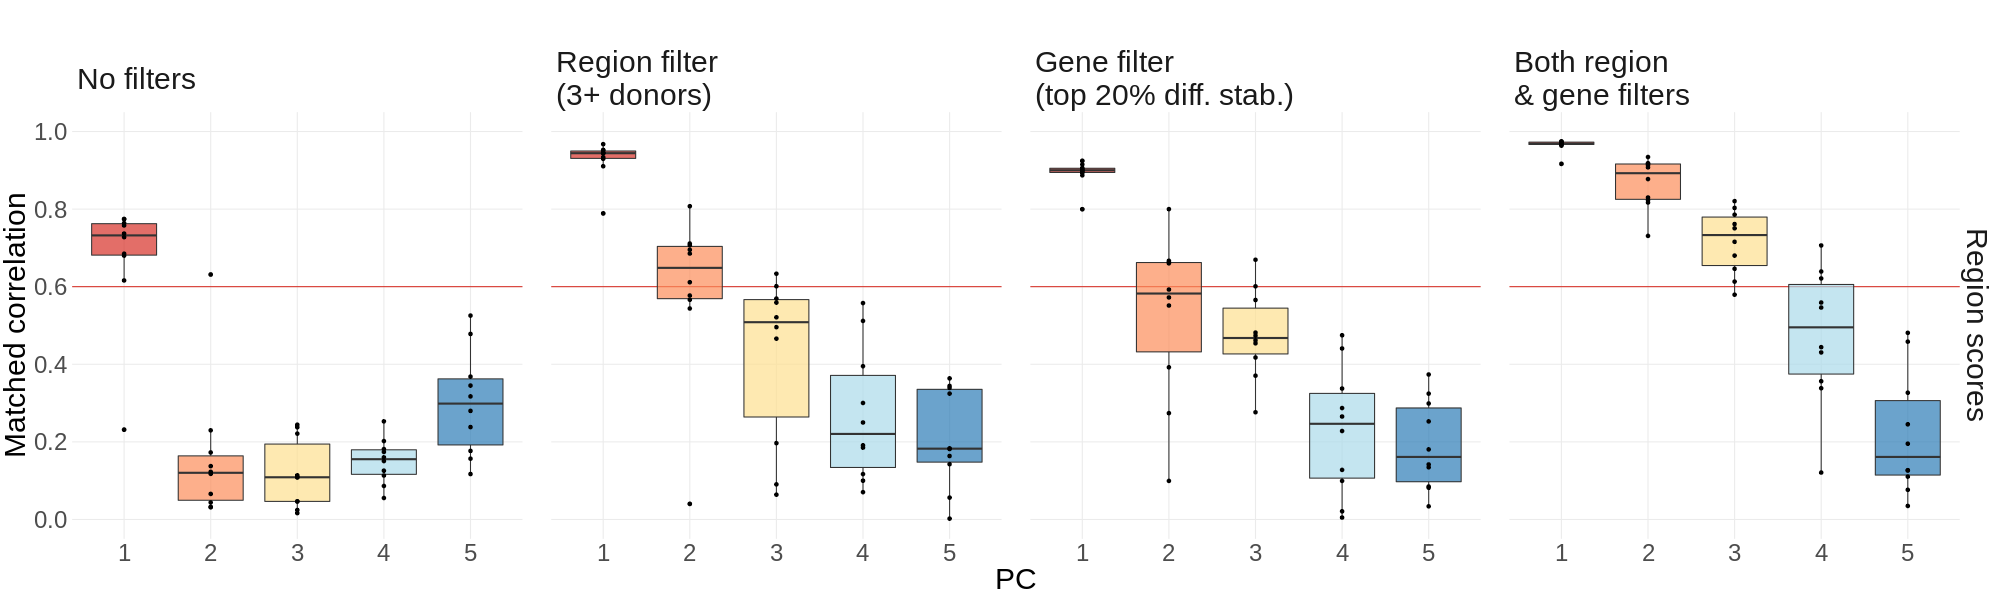

In [148]:
%%R -w 2000 -h 600 -i triplet_versions
plot_triplets(triplet_versions) & theme(text=element_text(size=30))

This looks good! Same overall story.

What about normalized angle kernel instead of gaussian?

In [86]:
triplet_versions_dict = {
    'No filters': filter_triplet_ds(triplets_hcp, ds_threshold=0, use_gradientVersion=True, approach='dm', kernel='normalized_angle'),
    'Region filter \n(3+ donors)': filter_triplet_ds(triplets_hcp_3donors, ds_threshold=0, use_gradientVersion=True, approach='dm', kernel='normalized_angle'),
    'Gene filter \n(top 20% diff. stab.)': filter_triplet_ds(triplets_hcp, ds_threshold=0.8, use_gradientVersion=True, approach='dm', kernel='normalized_angle'),
    'Both region \n& gene filters': filter_triplet_ds(triplets_hcp_3donors, ds_threshold=0.8, use_gradientVersion=True, approach='dm', kernel='normalized_angle')
}

triplet_versions = make_triplet_versions_plot(triplet_versions_dict, with_coefs=False)

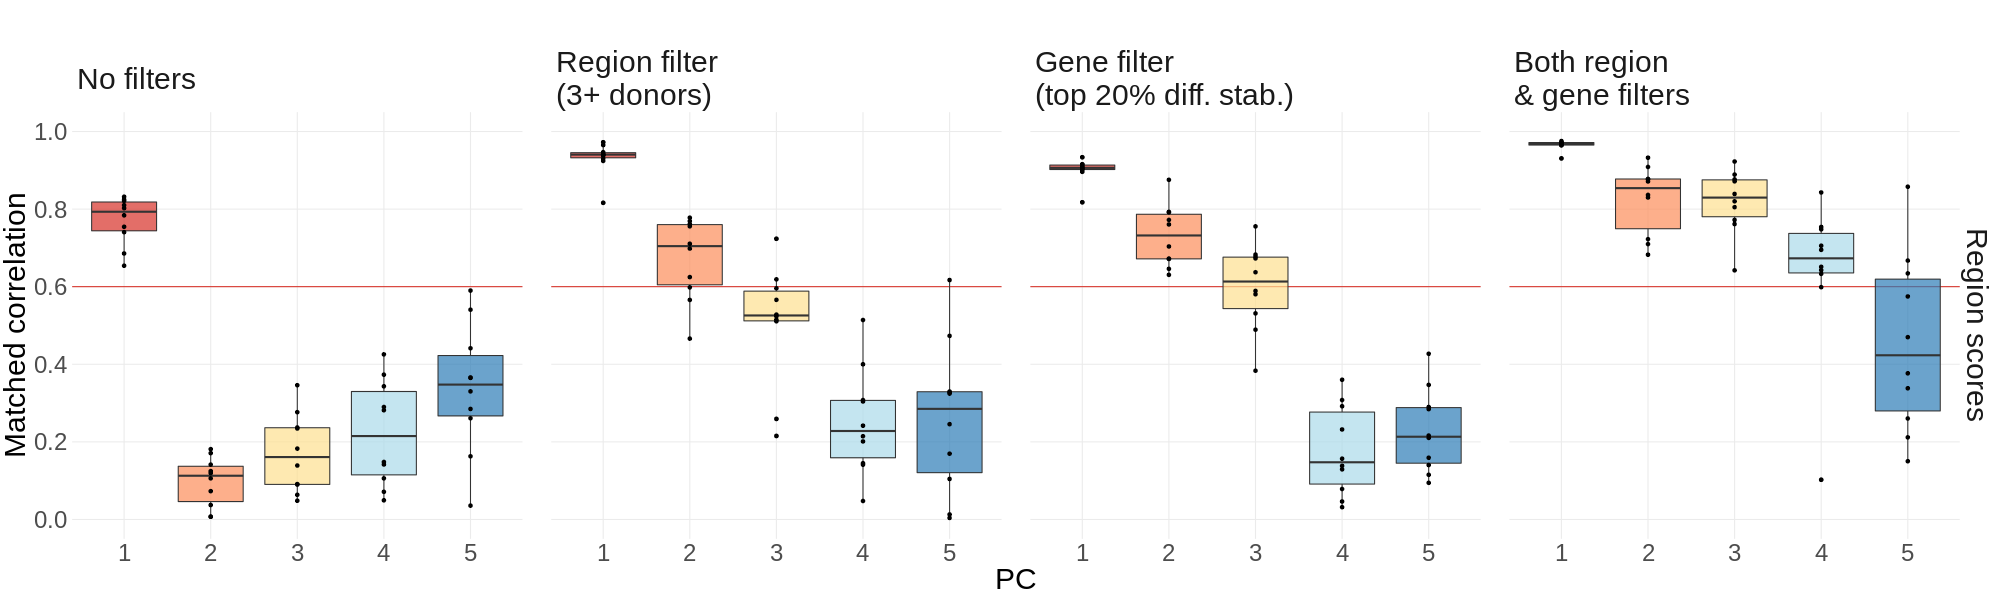

In [87]:
%%R -w 2000 -h 600 -i triplet_versions
plot_triplets(triplet_versions) & theme(text=element_text(size=30))

# 3 Changing DS level

Goal is to retain more genes, so does DM let us reduce the DS filter?

In [315]:
triplets_ds_levels = {}
for ds in [i/10 for i in range(0,10)]:
     triplets_ds_levels[ds] = filter_triplet_ds(triplets_hcp_3donors, ds)

In [316]:
triplet_versions = make_triplet_ds_plot(triplets_ds_levels)

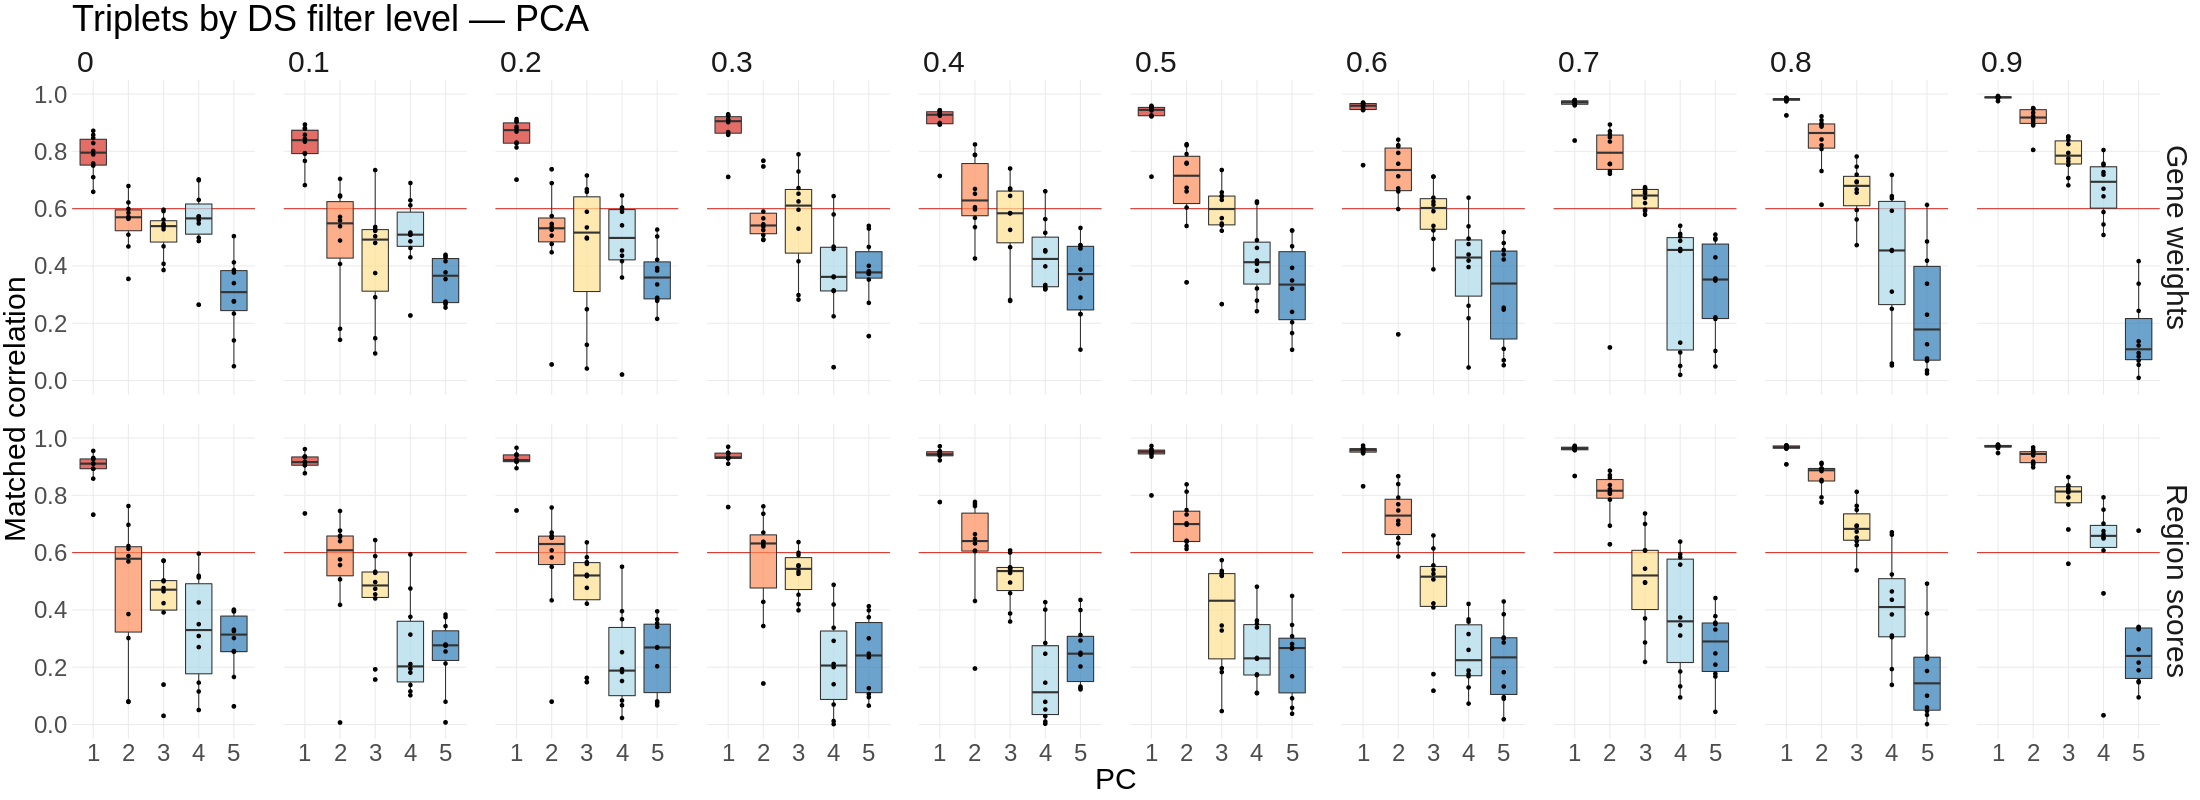

In [317]:
%%R -w 2200 -h 800 -i triplet_versions
plot_triplets(triplet_versions) + ggtitle('Triplets by DS filter level — PCA') & theme(text=element_text(size=30))

## Gradient versions

In [338]:
pca_linear = make_triplet_ds_plot(get_triplets_ds_levels(use_gradientVersion=True, approach='pca'), with_coefs=False)
# pca_kernel = make_triplet_ds_plot(get_triplets_ds_levels(use_gradientVersion=True, approach='pca', kernel='gaussian'), with_coefs=False)
diffmap_cosine_norm = make_triplet_ds_plot(get_triplets_ds_levels(use_gradientVersion=True, approach='dm', kernel='normalized_angle', alpha=1), with_coefs=False)
diffmap_gaussian = make_triplet_ds_plot(get_triplets_ds_levels(use_gradientVersion=True, approach='dm', kernel='gaussian', alpha=1), with_coefs=False)
diffmap_gaussian_gamma = make_triplet_ds_plot(get_triplets_ds_levels(use_gradientVersion=True, approach='dm', kernel='gaussian', gamma=1/600, alpha=1), with_coefs=False)

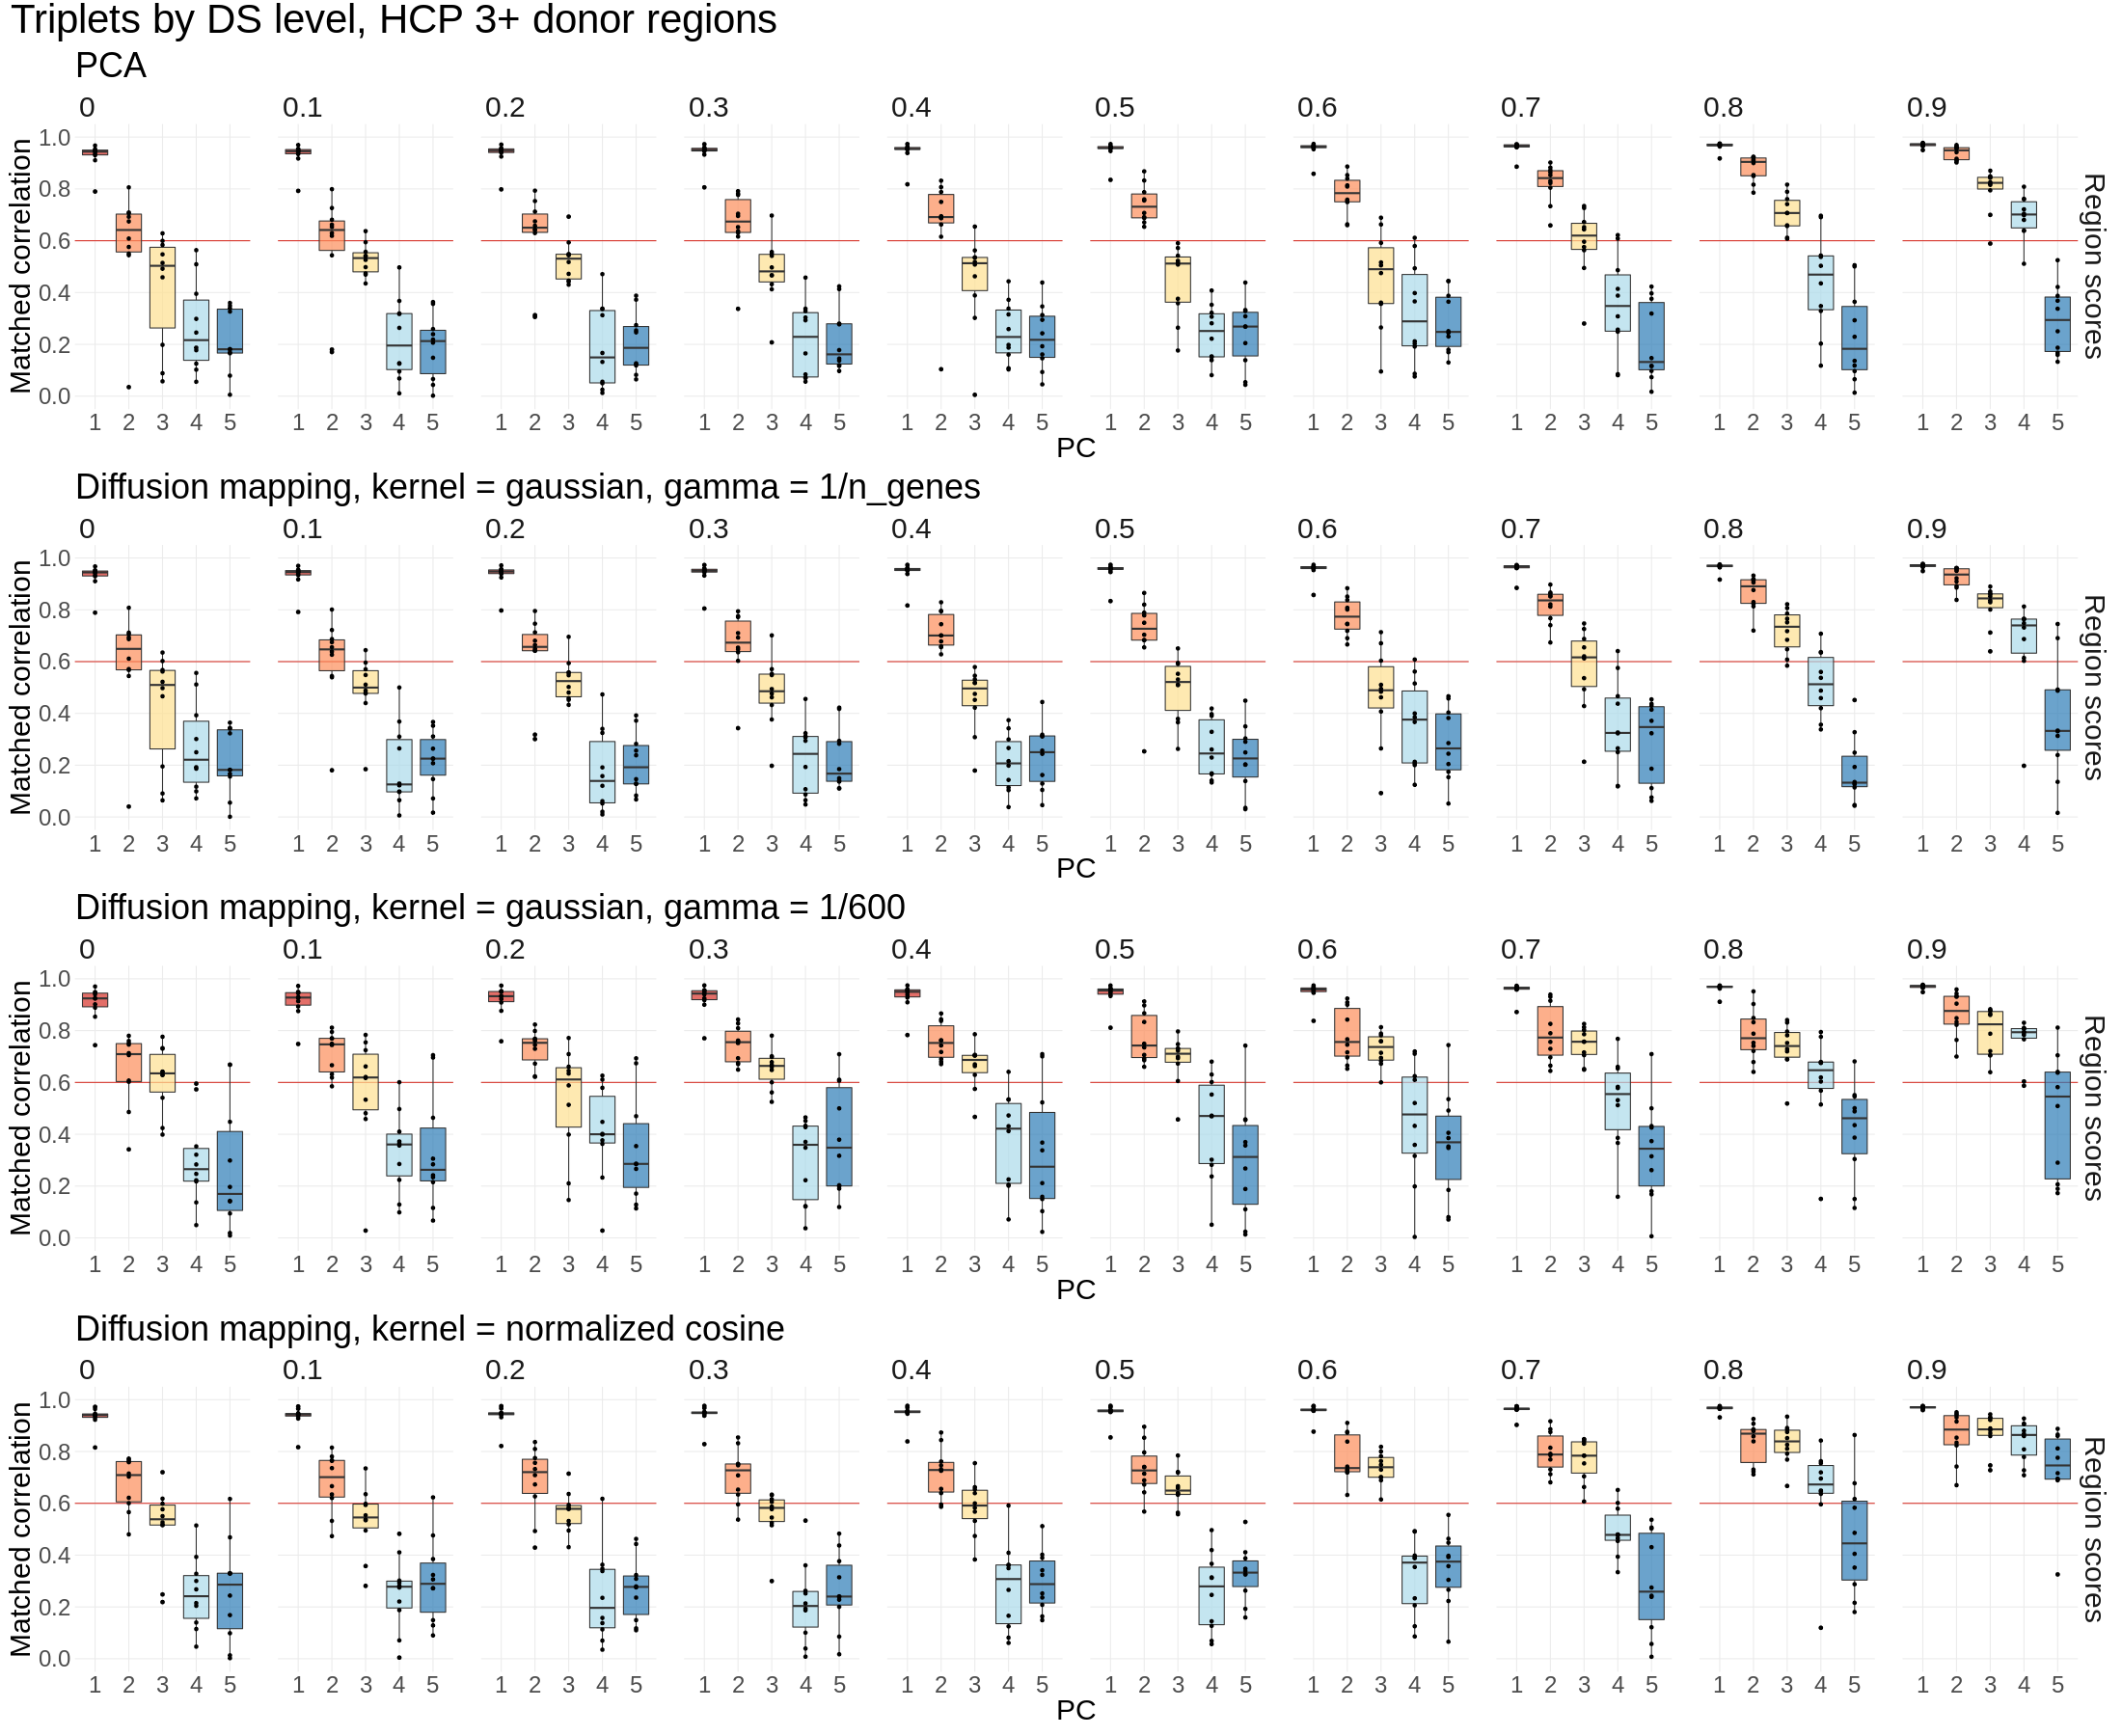

In [340]:
%%R -w 2200 -h 1800 -i pca_linear -i pca_kernel -i diffmap_cosine_norm -i diffmap_gaussian -i diffmap_gaussian_gamma
g1 <- plot_triplets(pca_linear) + ggtitle('PCA')
# g2 <- plot_triplets(pca_kernel) + ggtitle('Triplets by DS level — kernel PCA, kernel = normalized cosine')
g3 <- plot_triplets(diffmap_gaussian) + ggtitle('Diffusion mapping, kernel = gaussian, gamma = 1/n_genes')
g4 <- plot_triplets(diffmap_gaussian_gamma) + ggtitle('Diffusion mapping, kernel = gaussian, gamma = 1/600')
g5 <- plot_triplets(diffmap_cosine_norm) + ggtitle('Diffusion mapping, kernel = normalized cosine') 

((g1 / g3 / g4 / g5) & theme(text=element_text(size=30))) + 
plot_annotation(title='Triplets by DS level, HCP 3+ donor regions', theme = theme(plot.title = element_text(size = 42)))

## Varying alpha? Alpha = 1 is best

In [330]:
# pca_linear = make_triplet_ds_plot(get_triplets_ds_levels(use_gradientVersion=True, approach='pca'), with_coefs=False)
# pca_kernel = make_triplet_ds_plot(get_triplets_ds_levels(use_gradientVersion=True, approach='pca', kernel='gaussian'), with_coefs=False)
diffmap_cosine_norm_alpha5 = make_triplet_ds_plot(get_triplets_ds_levels(use_gradientVersion=True, approach='dm', kernel='normalized_angle', alpha=.5), with_coefs=False)
diffmap_cosine_norm_alpha0 = make_triplet_ds_plot(get_triplets_ds_levels(use_gradientVersion=True, approach='dm', kernel='normalized_angle', alpha=0), with_coefs=False)
diffmap_cosine_norm_alpha10 = make_triplet_ds_plot(get_triplets_ds_levels(use_gradientVersion=True, approach='dm', kernel='normalized_angle', alpha=1), with_coefs=False)
# diffmap_gaussian = make_triplet_ds_plot(get_triplets_ds_levels(use_gradientVersion=True, approach='dm', kernel='gaussian'), with_coefs=False)
# diffmap_gaussian_gamma = make_triplet_ds_plot(get_triplets_ds_levels(use_gradientVersion=True, approach='dm', kernel='gaussian', gamma=1/600), with_coefs=False)

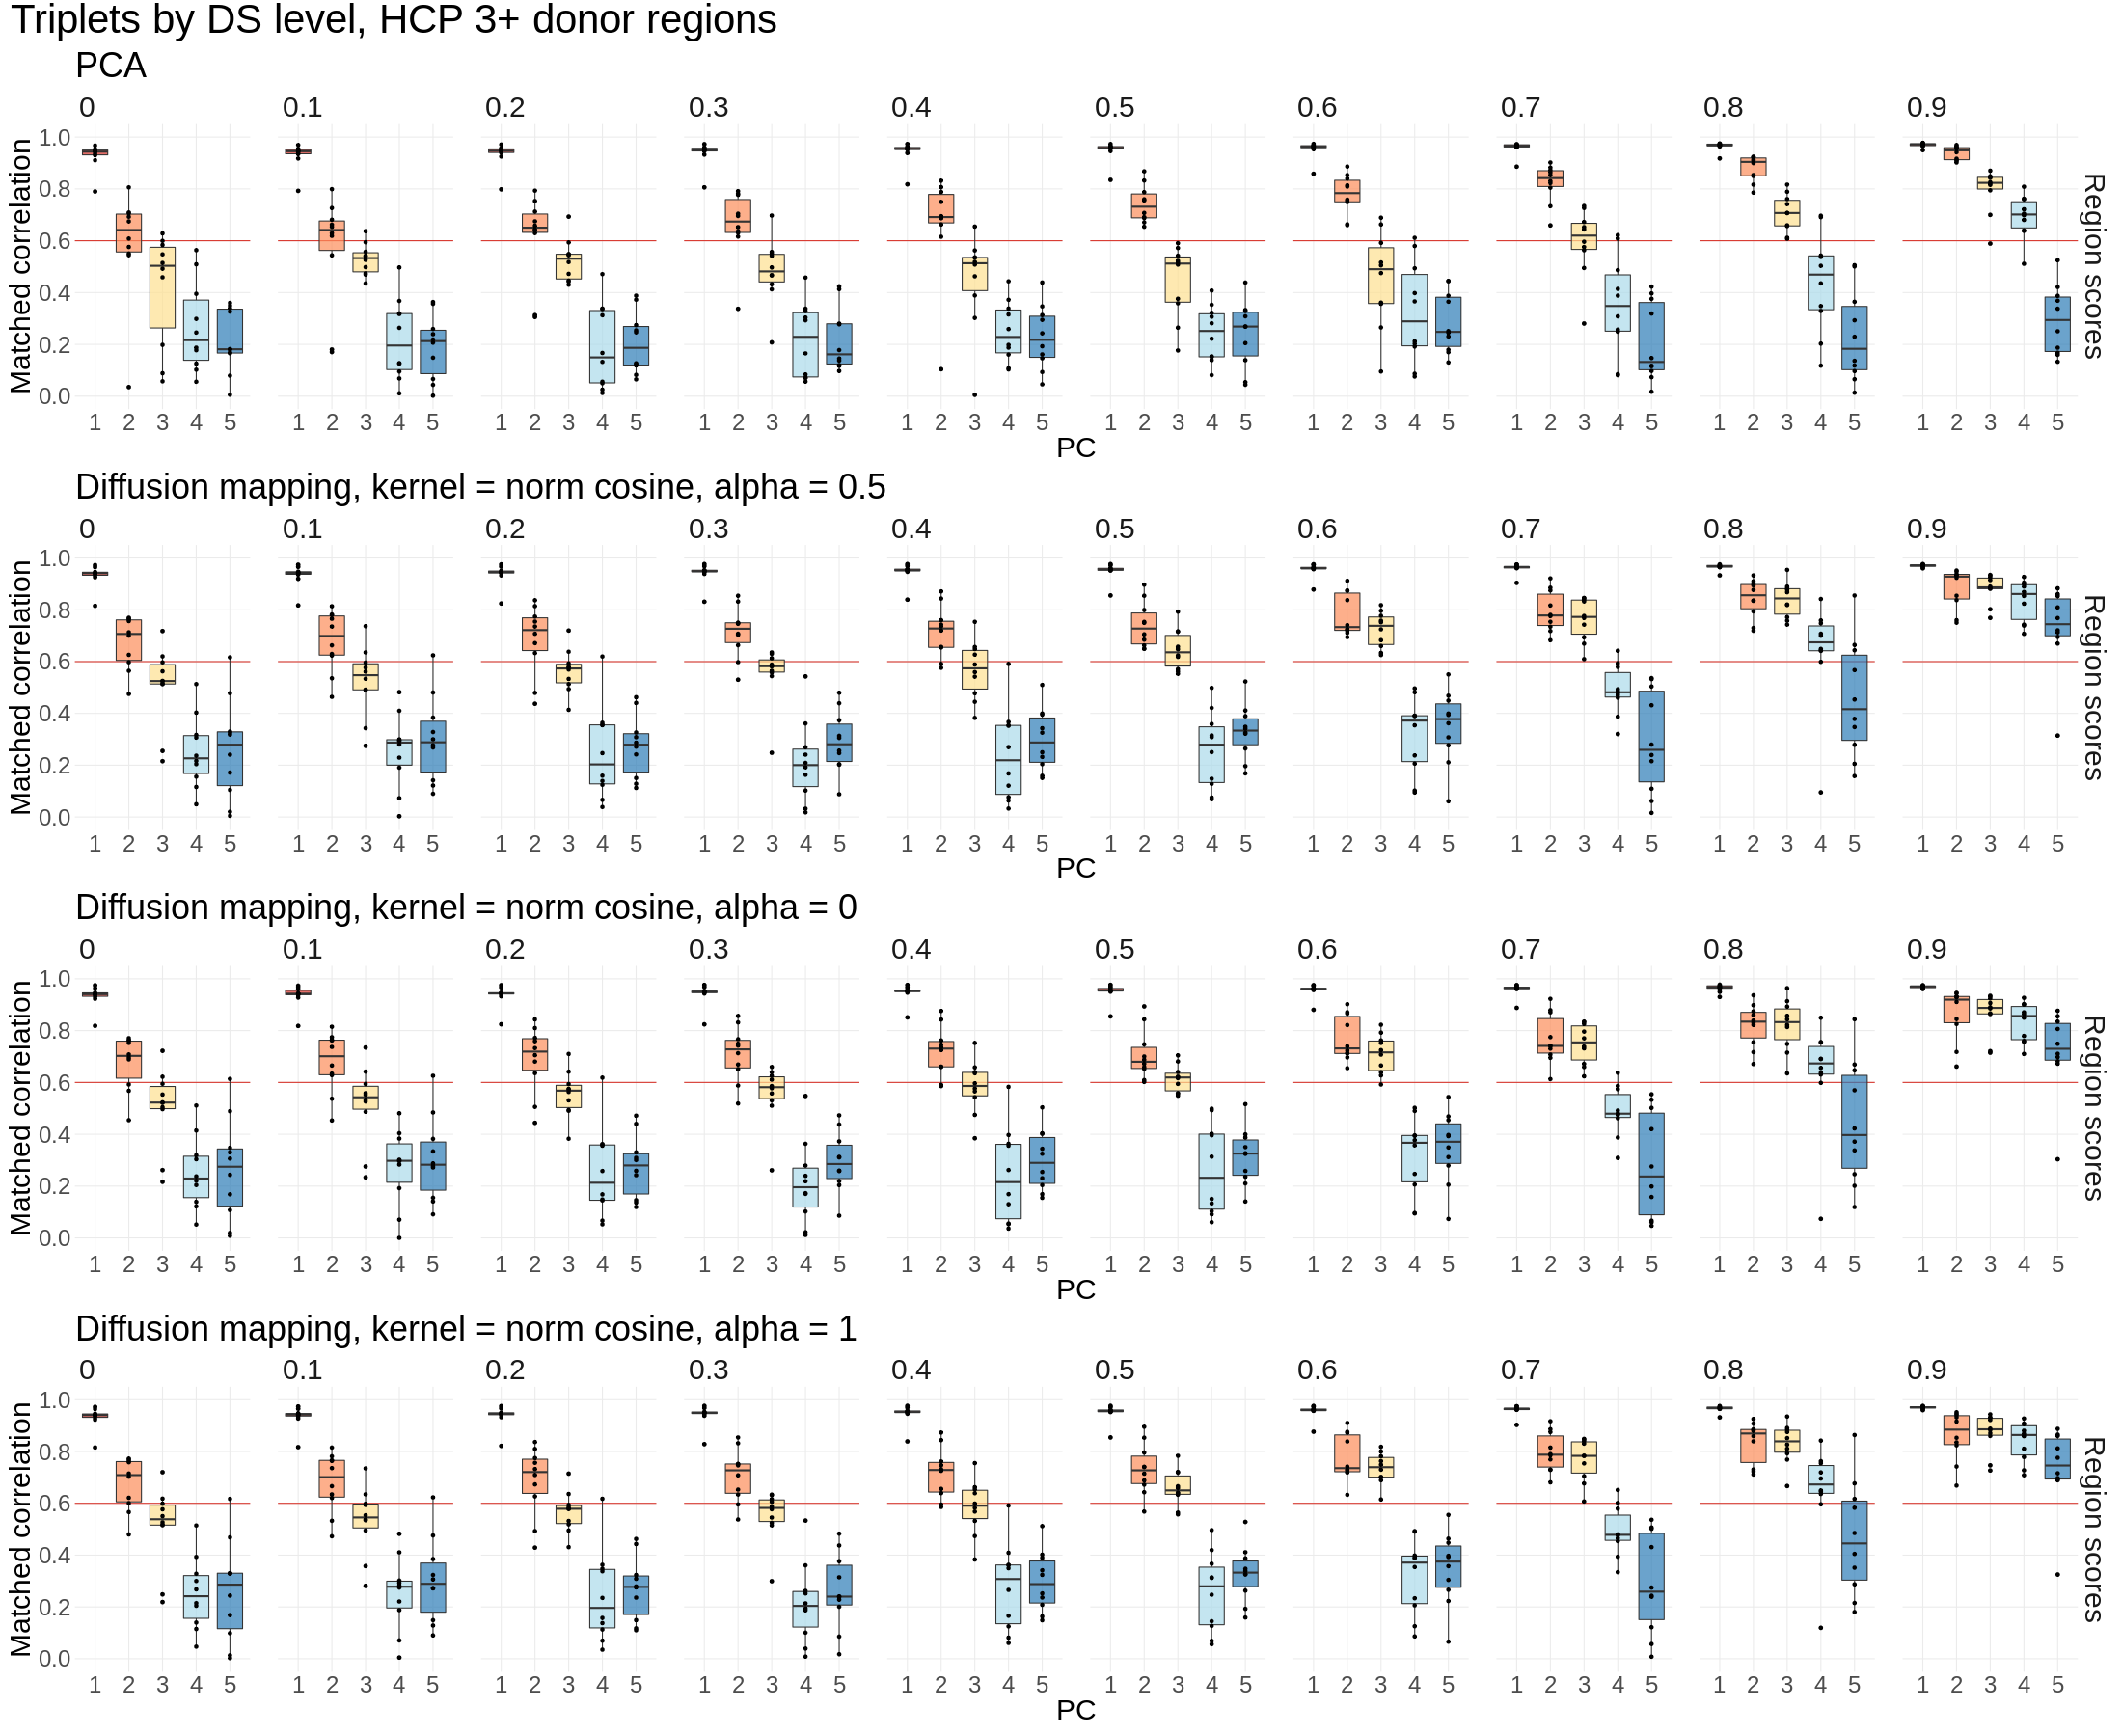

In [332]:
%%R -w 2200 -h 1800 -i pca_linear -i pca_kernel -i diffmap_cosine_norm_alpha5 -i diffmap_cosine_norm_alpha0 -i diffmap_cosine_norm_alpha10
g1 <- plot_triplets(pca_linear) + ggtitle('PCA')
# g2 <- plot_triplets(pca_kernel) + ggtitle('Triplets by DS level — kernel PCA, kernel = normalized cosine')
g3 <- plot_triplets(diffmap_cosine_norm_alpha5) + ggtitle('Diffusion mapping, kernel = norm cosine, alpha = 0.5')
g4 <- plot_triplets(diffmap_cosine_norm_alpha0) + ggtitle('Diffusion mapping, kernel = norm cosine, alpha = 0')
g5 <- plot_triplets(diffmap_cosine_norm_alpha10) + ggtitle('Diffusion mapping, kernel = norm cosine, alpha = 1') 

((g1 / g3 / g4 / g5) & theme(text=element_text(size=30))) + 
plot_annotation(title='Triplets by DS level, HCP 3+ donor regions', theme = theme(plot.title = element_text(size = 42)))

## Gradient versions in MNI

In [171]:
# triplets_hcp_mni = load_pickle("triplets_hcp_mni")
triplets_hcp_mni_3donors = load_pickle("triplets_hcp_mni_3donors")

In [341]:
pca_linear = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp_mni_3donors, use_gradientVersion=True, approach='pca'), with_coefs=False)
diffmap_cosine_norm = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp_mni_3donors, use_gradientVersion=True, approach='dm', kernel='normalized_angle', alpha=1), with_coefs=False)
diffmap_gaussian = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp_mni_3donors, use_gradientVersion=True, approach='dm', kernel='gaussian', alpha=1), with_coefs=False)
# diffmap_gaussian_gamma = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp_mni_3donors, use_gradientVersion=True, approach='dm', kernel='gaussian', gamma=1/600, alpha=1), with_coefs=False)

/home/rajd2/.local/lib/python3.8/site-packages/brainspace/gradient/embedding.py:77: UserWarning: Graph is not fully connected.
  warnings.warn('Graph is not fully connected.')


ArpackNoConvergence: ARPACK error -1: No convergence (661 iterations, 0/6 eigenvectors converged)

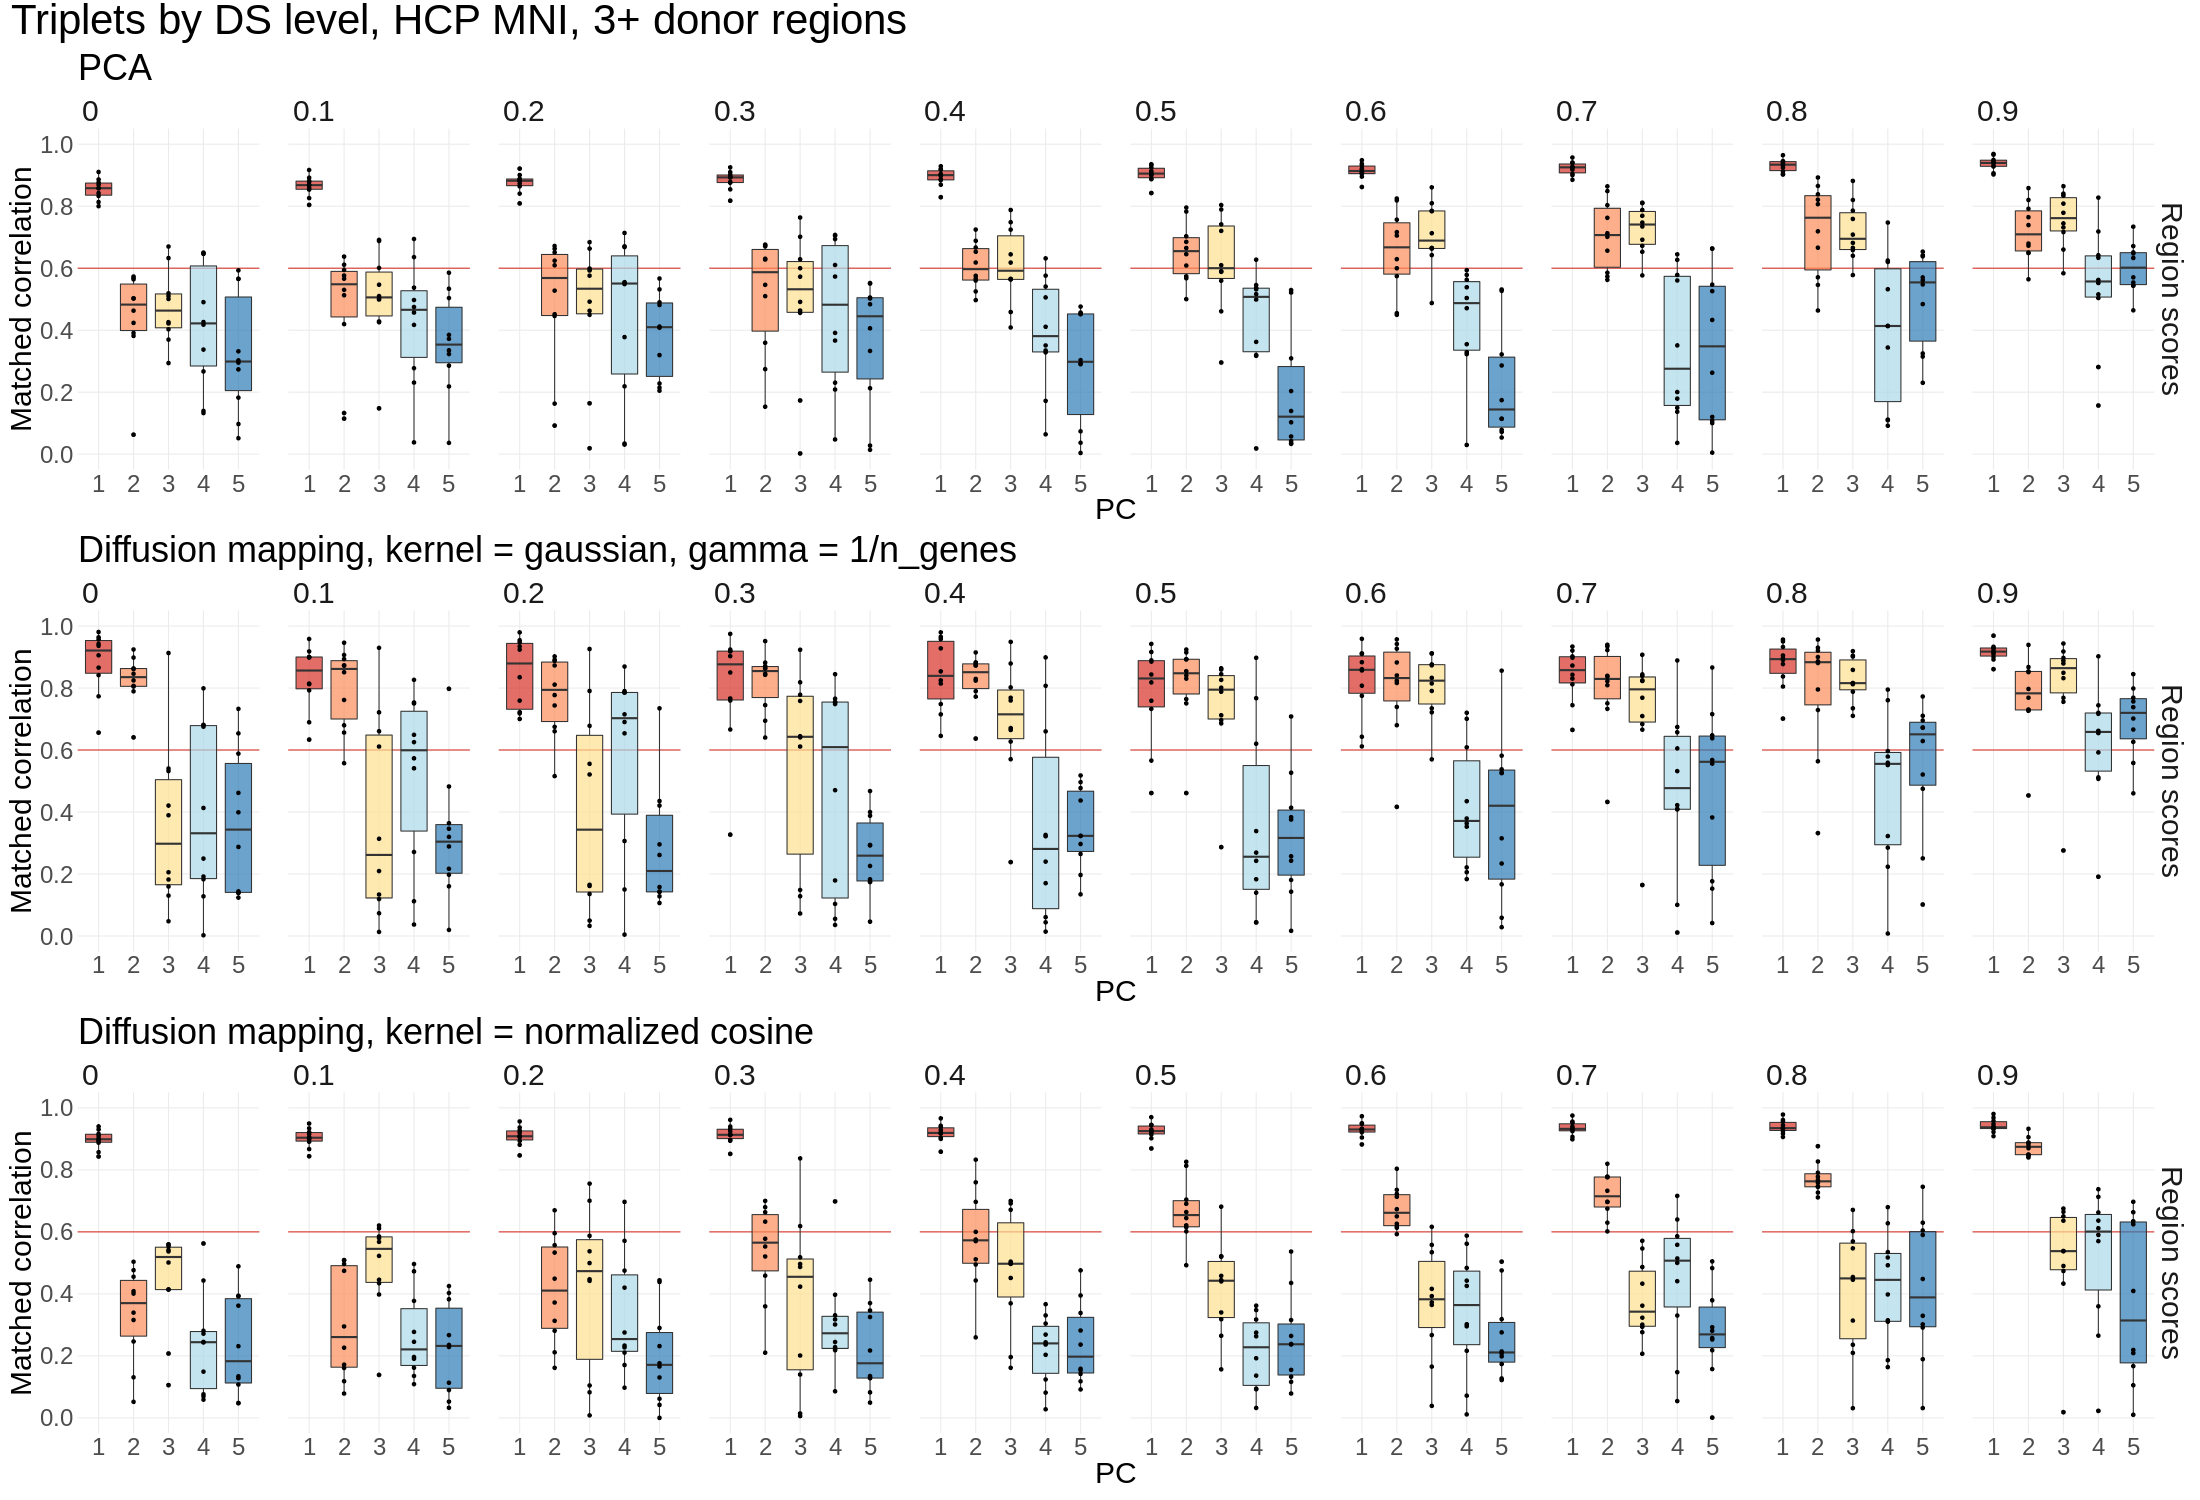

In [342]:
%%R -w 2200 -h 1500 -i pca_linear -i pca_kernel -i diffmap_cosine_norm -i diffmap_gaussian
g1 <- plot_triplets(pca_linear) + ggtitle('PCA')
# g2 <- plot_triplets(pca_kernel) + ggtitle('Triplets by DS level — kernel PCA, kernel = normalized cosine')
g3 <- plot_triplets(diffmap_gaussian) + ggtitle('Diffusion mapping, kernel = gaussian, gamma = 1/n_genes')
# g4 <- plot_triplets(diffmap_gaussian_gamma) + ggtitle('Diffusion mapping, kernel = gaussian, gamma = 1/600')
g5 <- plot_triplets(diffmap_cosine_norm) + ggtitle('Diffusion mapping, kernel = normalized cosine') 

((g1 / g3 / g5) & theme(text=element_text(size=30))) + 
plot_annotation(title='Triplets by DS level, HCP MNI, 3+ donor regions', theme = theme(plot.title = element_text(size = 42)))

## 2-donors rather than 3-donors?

In [343]:
pca_linear = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp_2donors, use_gradientVersion=True, approach='pca'), with_coefs=False)
diffmap_cosine_norm = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp_2donors, use_gradientVersion=True, approach='dm', kernel='normalized_angle', alpha=1), with_coefs=False)
diffmap_gaussian = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp_2donors, use_gradientVersion=True, approach='dm', kernel='gaussian', alpha=1), with_coefs=False)
diffmap_gaussian_gamma = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp_2donors, use_gradientVersion=True, approach='dm', kernel='gaussian', gamma=1/600, alpha=1), with_coefs=False)

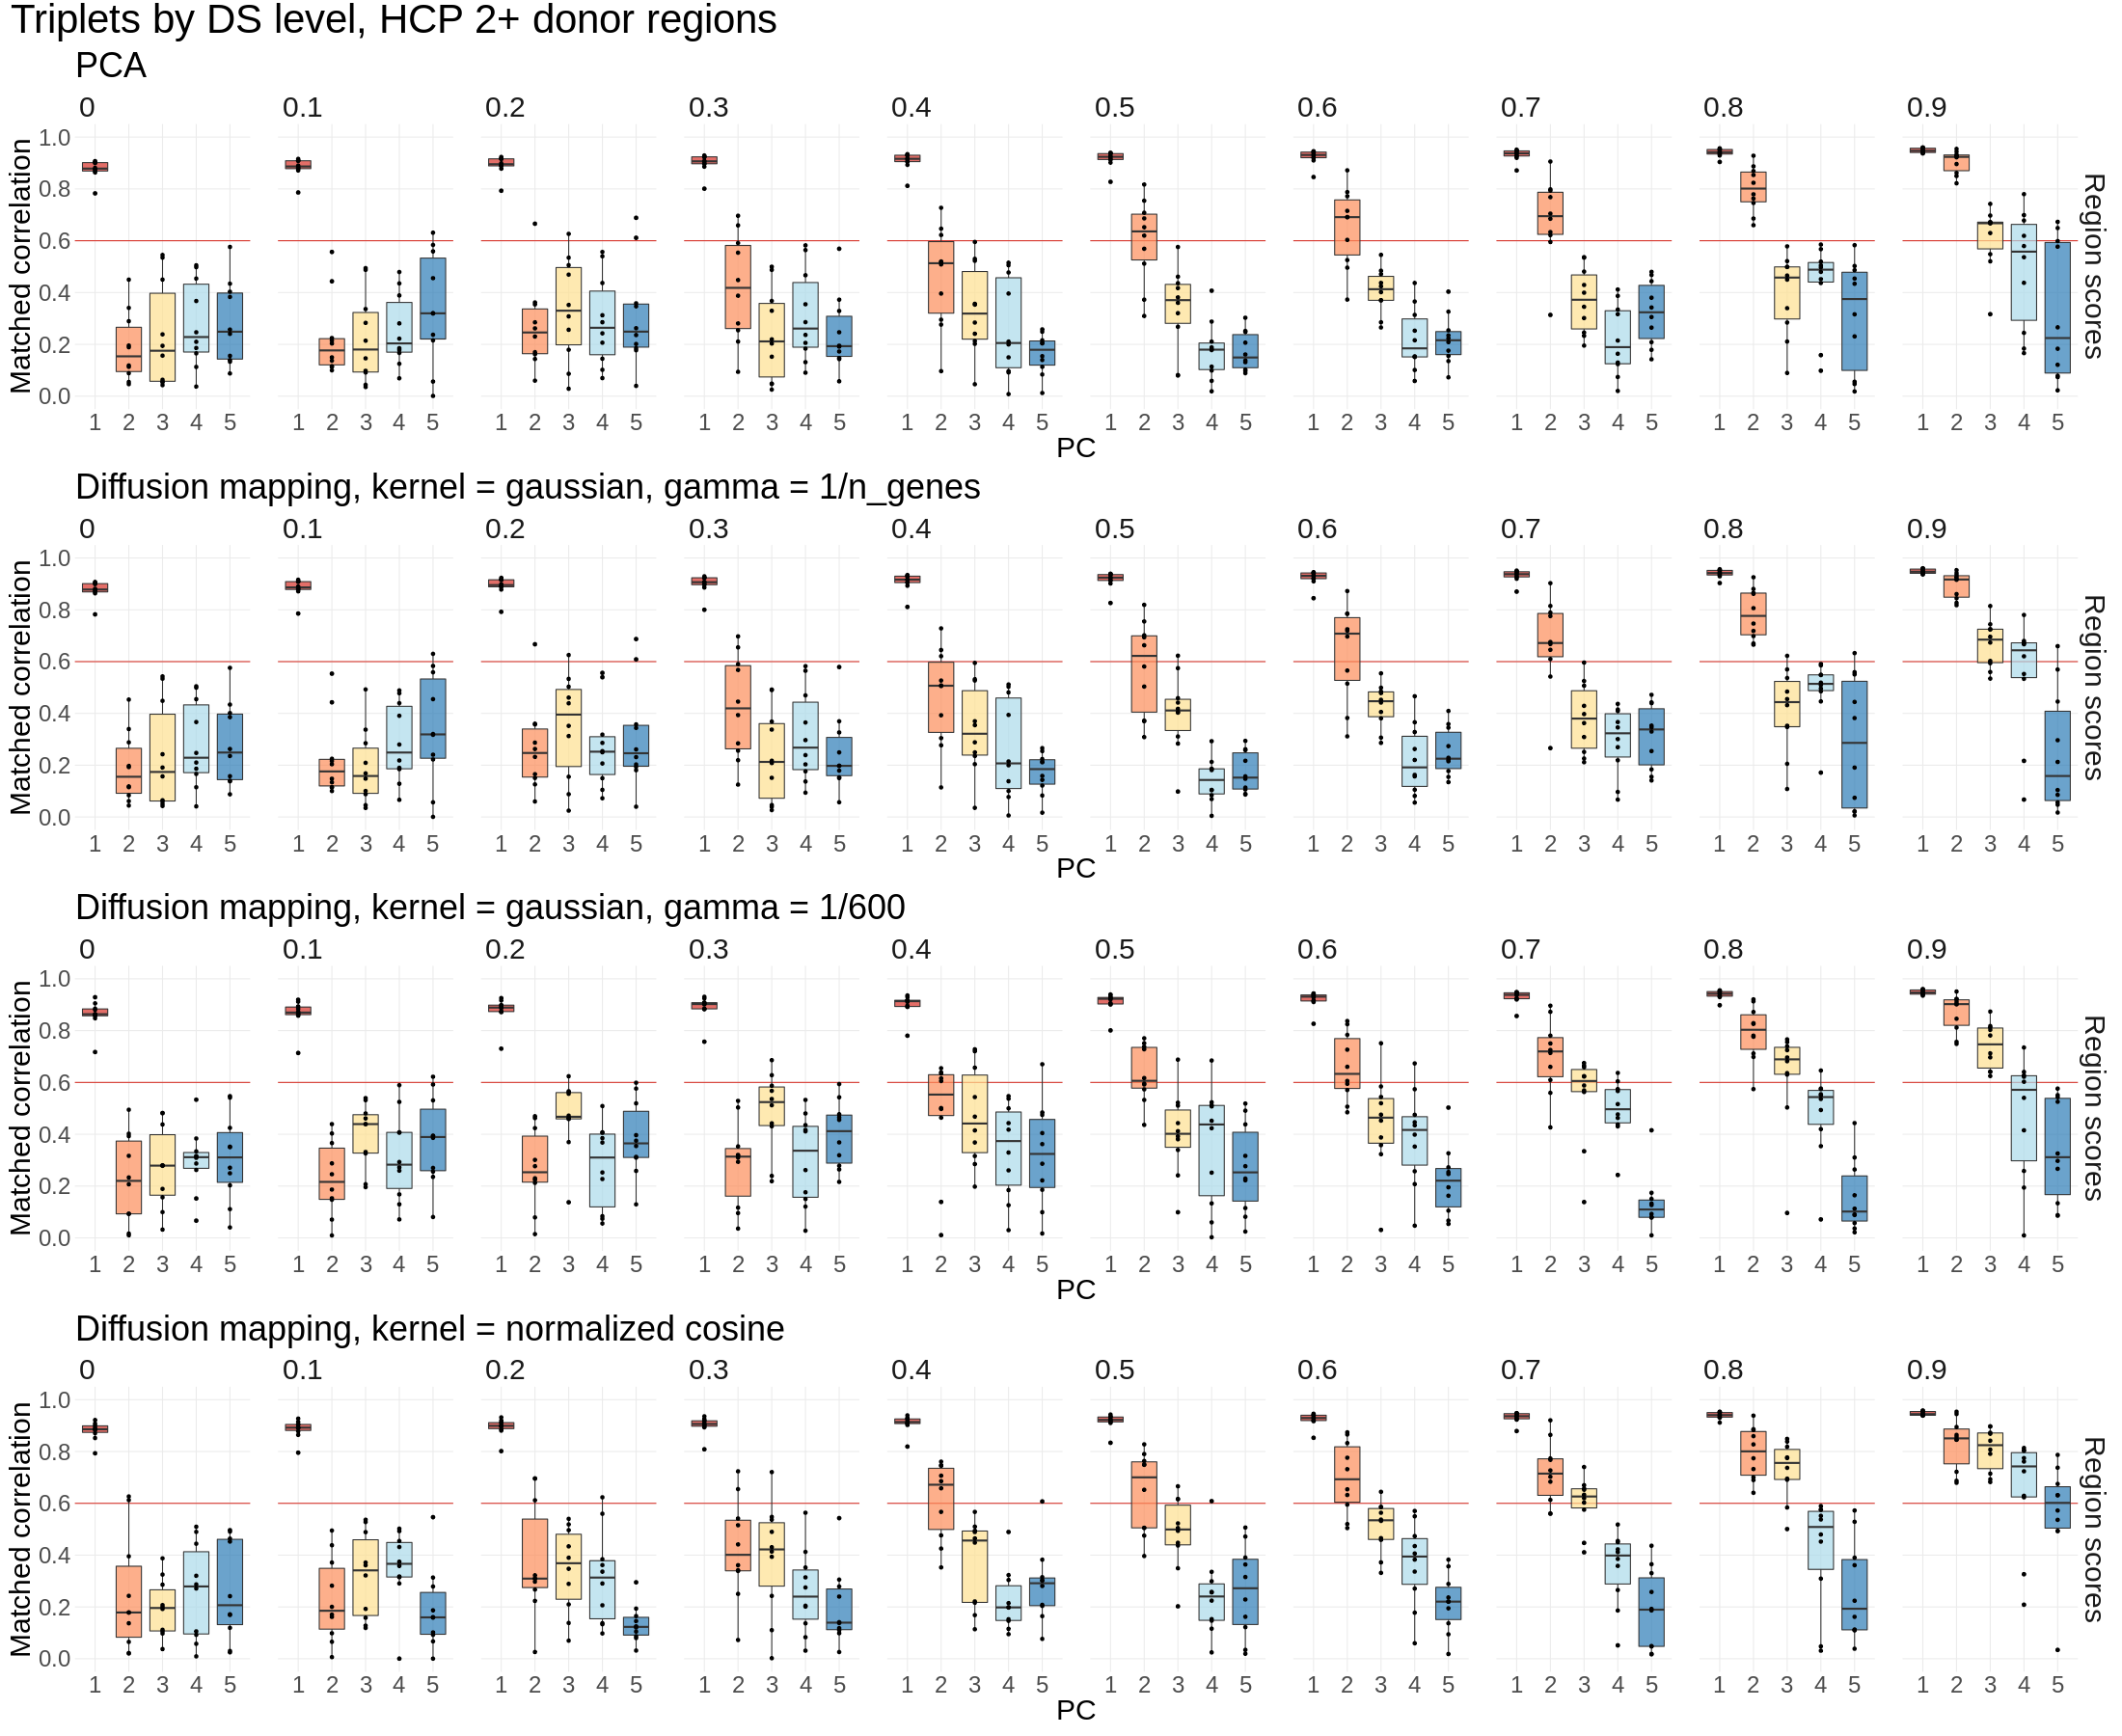

In [345]:
%%R -w 2200 -h 1800 -i pca_linear -i pca_kernel -i diffmap_cosine_norm -i diffmap_gaussian -i diffmap_gaussian_gamma
g1 <- plot_triplets(pca_linear) + ggtitle('PCA')
# g2 <- plot_triplets(pca_kernel) + ggtitle('Triplets by DS level — kernel PCA, kernel = normalized cosine')
g3 <- plot_triplets(diffmap_gaussian) + ggtitle('Diffusion mapping, kernel = gaussian, gamma = 1/n_genes')
g4 <- plot_triplets(diffmap_gaussian_gamma) + ggtitle('Diffusion mapping, kernel = gaussian, gamma = 1/600')
g5 <- plot_triplets(diffmap_cosine_norm) + ggtitle('Diffusion mapping, kernel = normalized cosine') 

((g1 / g3 / g4 / g5) & theme(text=element_text(size=30))) + 
plot_annotation(title='Triplets by DS level, HCP 2+ donor regions', theme = theme(plot.title = element_text(size = 42)))

## All regions rather than 3-donors?

In [358]:
pca_linear = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp, use_gradientVersion=True, approach='pca'), with_coefs=False)
diffmap_cosine_norm = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp, use_gradientVersion=True, approach='dm', kernel='normalized_angle', alpha=1), with_coefs=False)
diffmap_gaussian = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp, use_gradientVersion=True, approach='dm', kernel='gaussian', alpha=1), with_coefs=False)
diffmap_gaussian_gamma = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp, use_gradientVersion=True, approach='dm', kernel='gaussian', gamma=1/600, alpha=1), with_coefs=False)

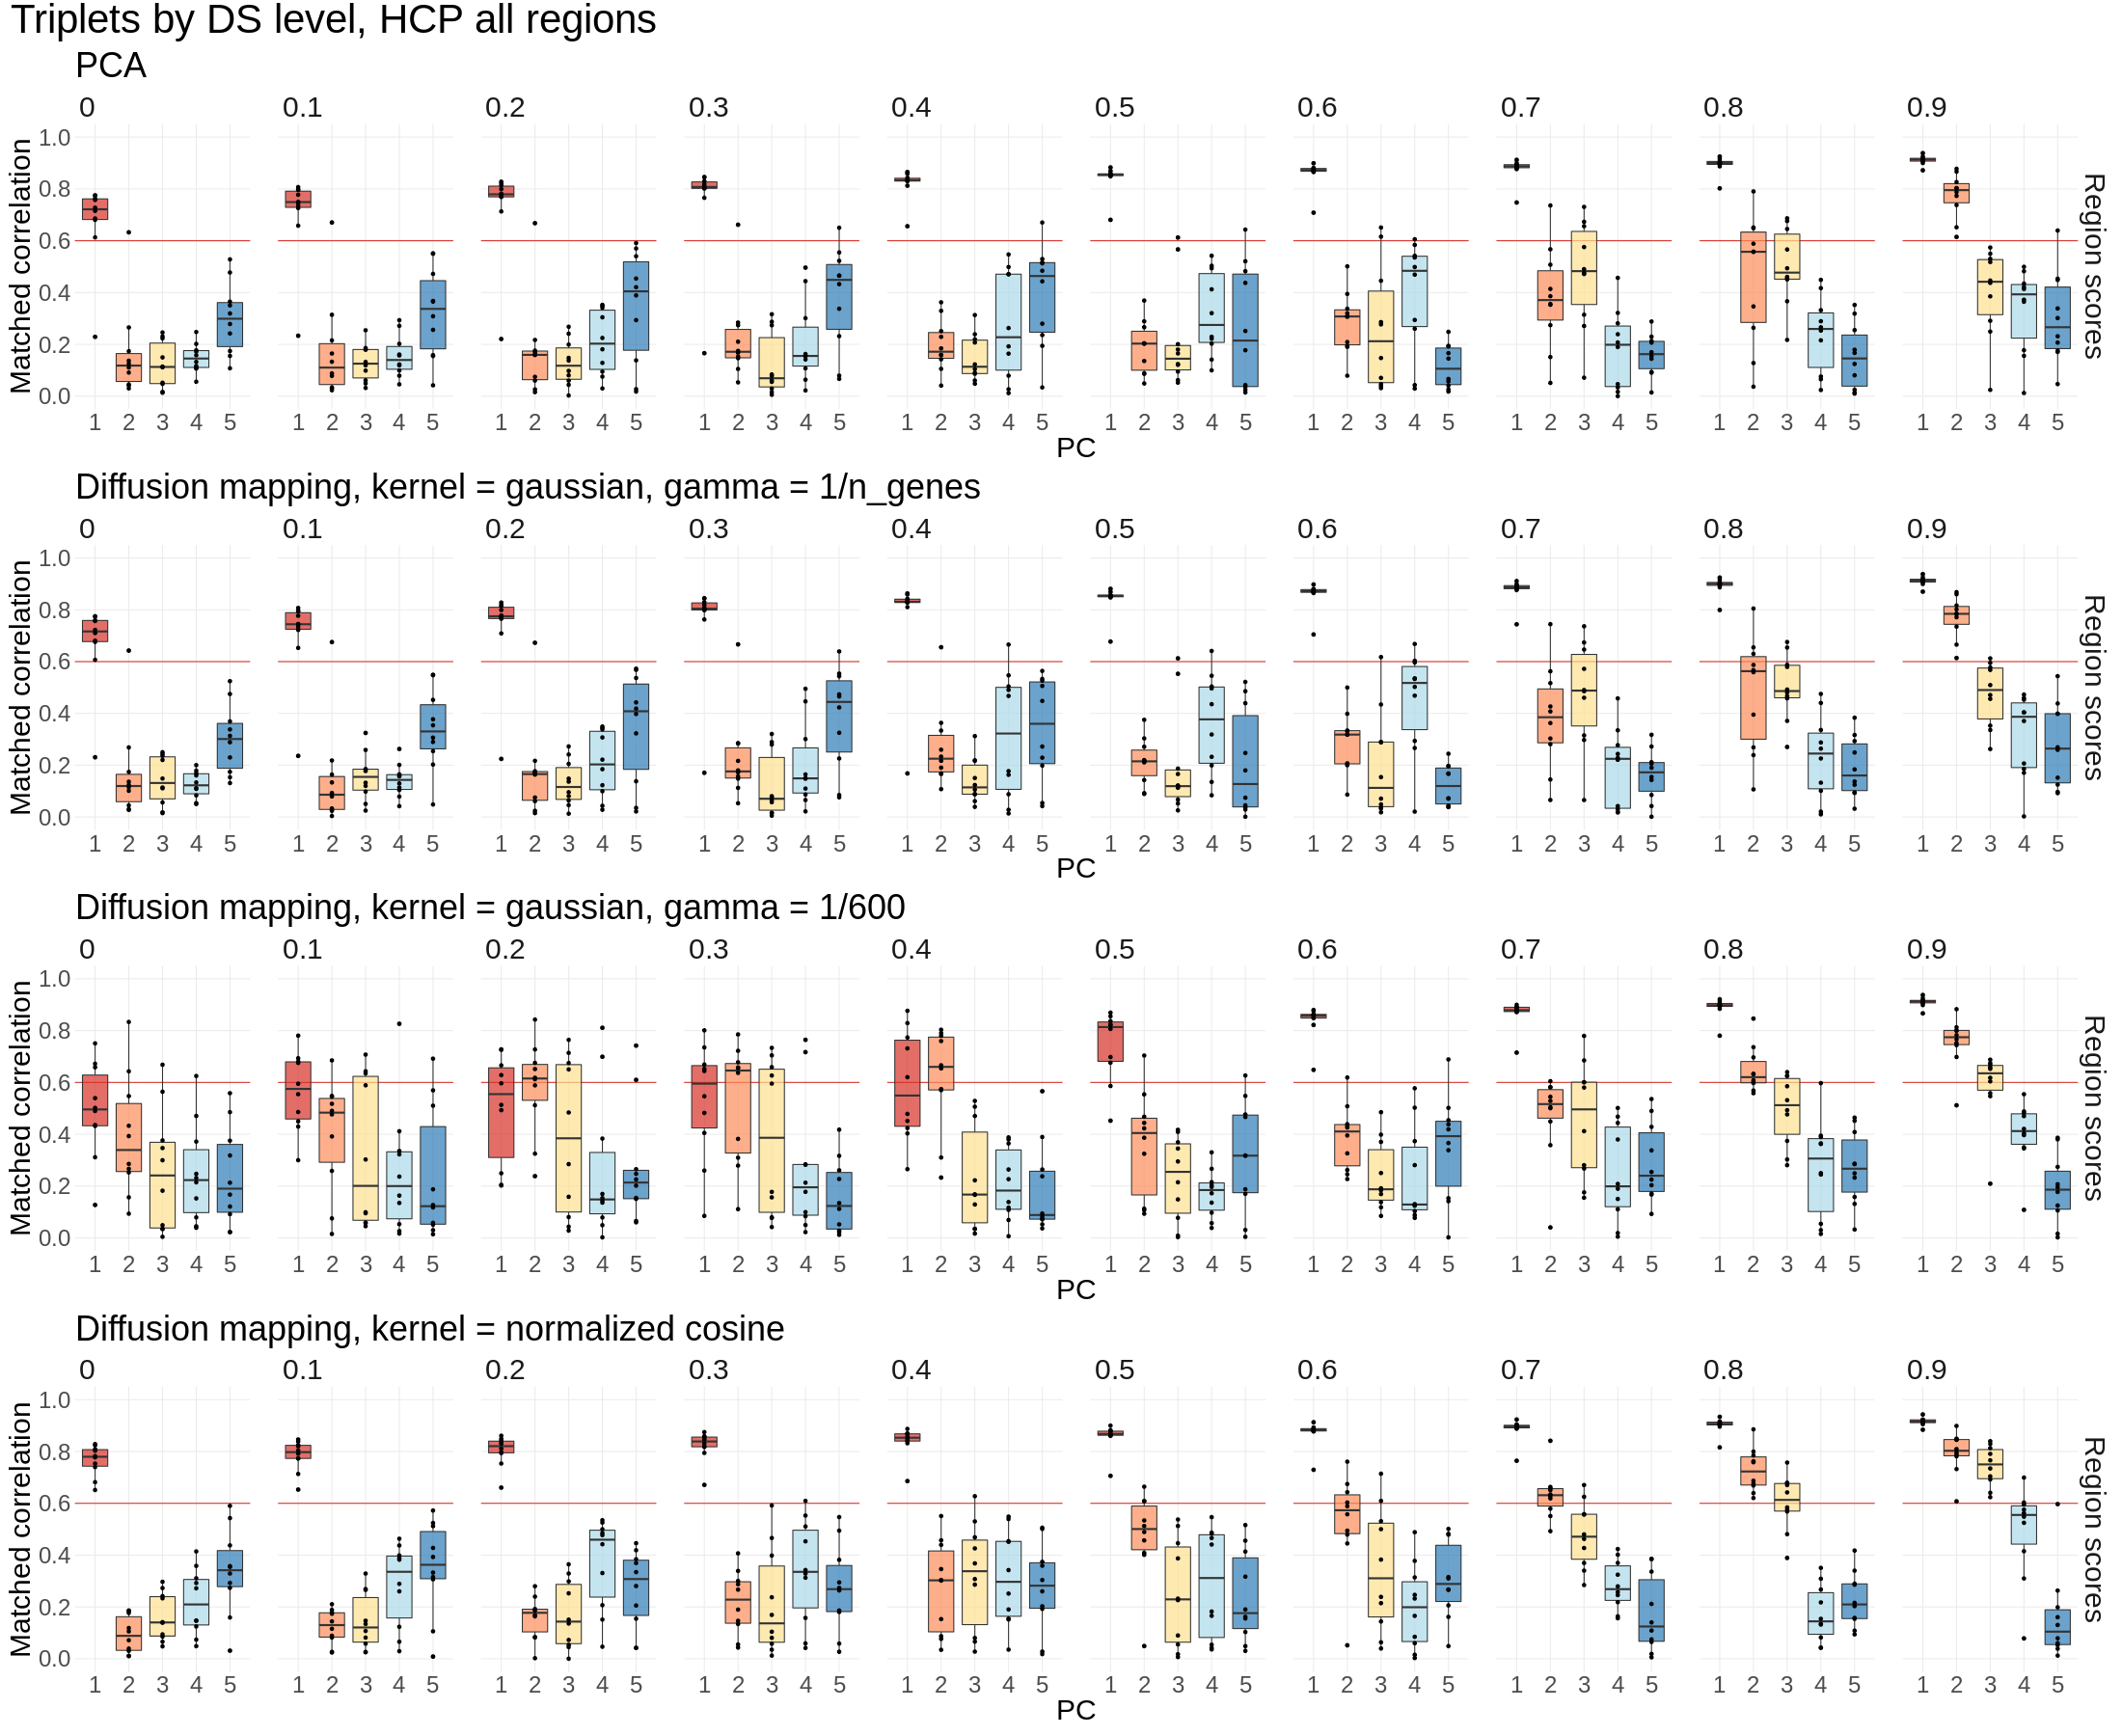

In [359]:
%%R -w 2200 -h 1800 -i pca_linear -i pca_kernel -i diffmap_cosine_norm -i diffmap_gaussian -i diffmap_gaussian_gamma
g1 <- plot_triplets(pca_linear) + ggtitle('PCA')
# g2 <- plot_triplets(pca_kernel) + ggtitle('Triplets by DS level — kernel PCA, kernel = normalized cosine')
g3 <- plot_triplets(diffmap_gaussian) + ggtitle('Diffusion mapping, kernel = gaussian, gamma = 1/n_genes')
g4 <- plot_triplets(diffmap_gaussian_gamma) + ggtitle('Diffusion mapping, kernel = gaussian, gamma = 1/600')
g5 <- plot_triplets(diffmap_cosine_norm) + ggtitle('Diffusion mapping, kernel = normalized cosine') 

((g1 / g3 / g4 / g5) & theme(text=element_text(size=30))) + 
plot_annotation(title='Triplets by DS level, HCP all regions', theme = theme(plot.title = element_text(size = 42)))

## Sparsity? Bad

In [349]:
pca_linear = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp_2donors, use_gradientVersion=True, approach='pca'), with_coefs=False)
diffmap_sparse0 = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp_2donors, use_gradientVersion=True, approach='dm', kernel='normalized_angle', alpha=1, sparsity=0), with_coefs=False)
diffmap_sparse2 = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp_2donors, use_gradientVersion=True, approach='dm', kernel='normalized_angle', alpha=1, sparsity=0.2), with_coefs=False)
diffmap_sparse5 = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp_2donors, use_gradientVersion=True, approach='dm', kernel='normalized_angle', alpha=1, sparsity=0.5), with_coefs=False)

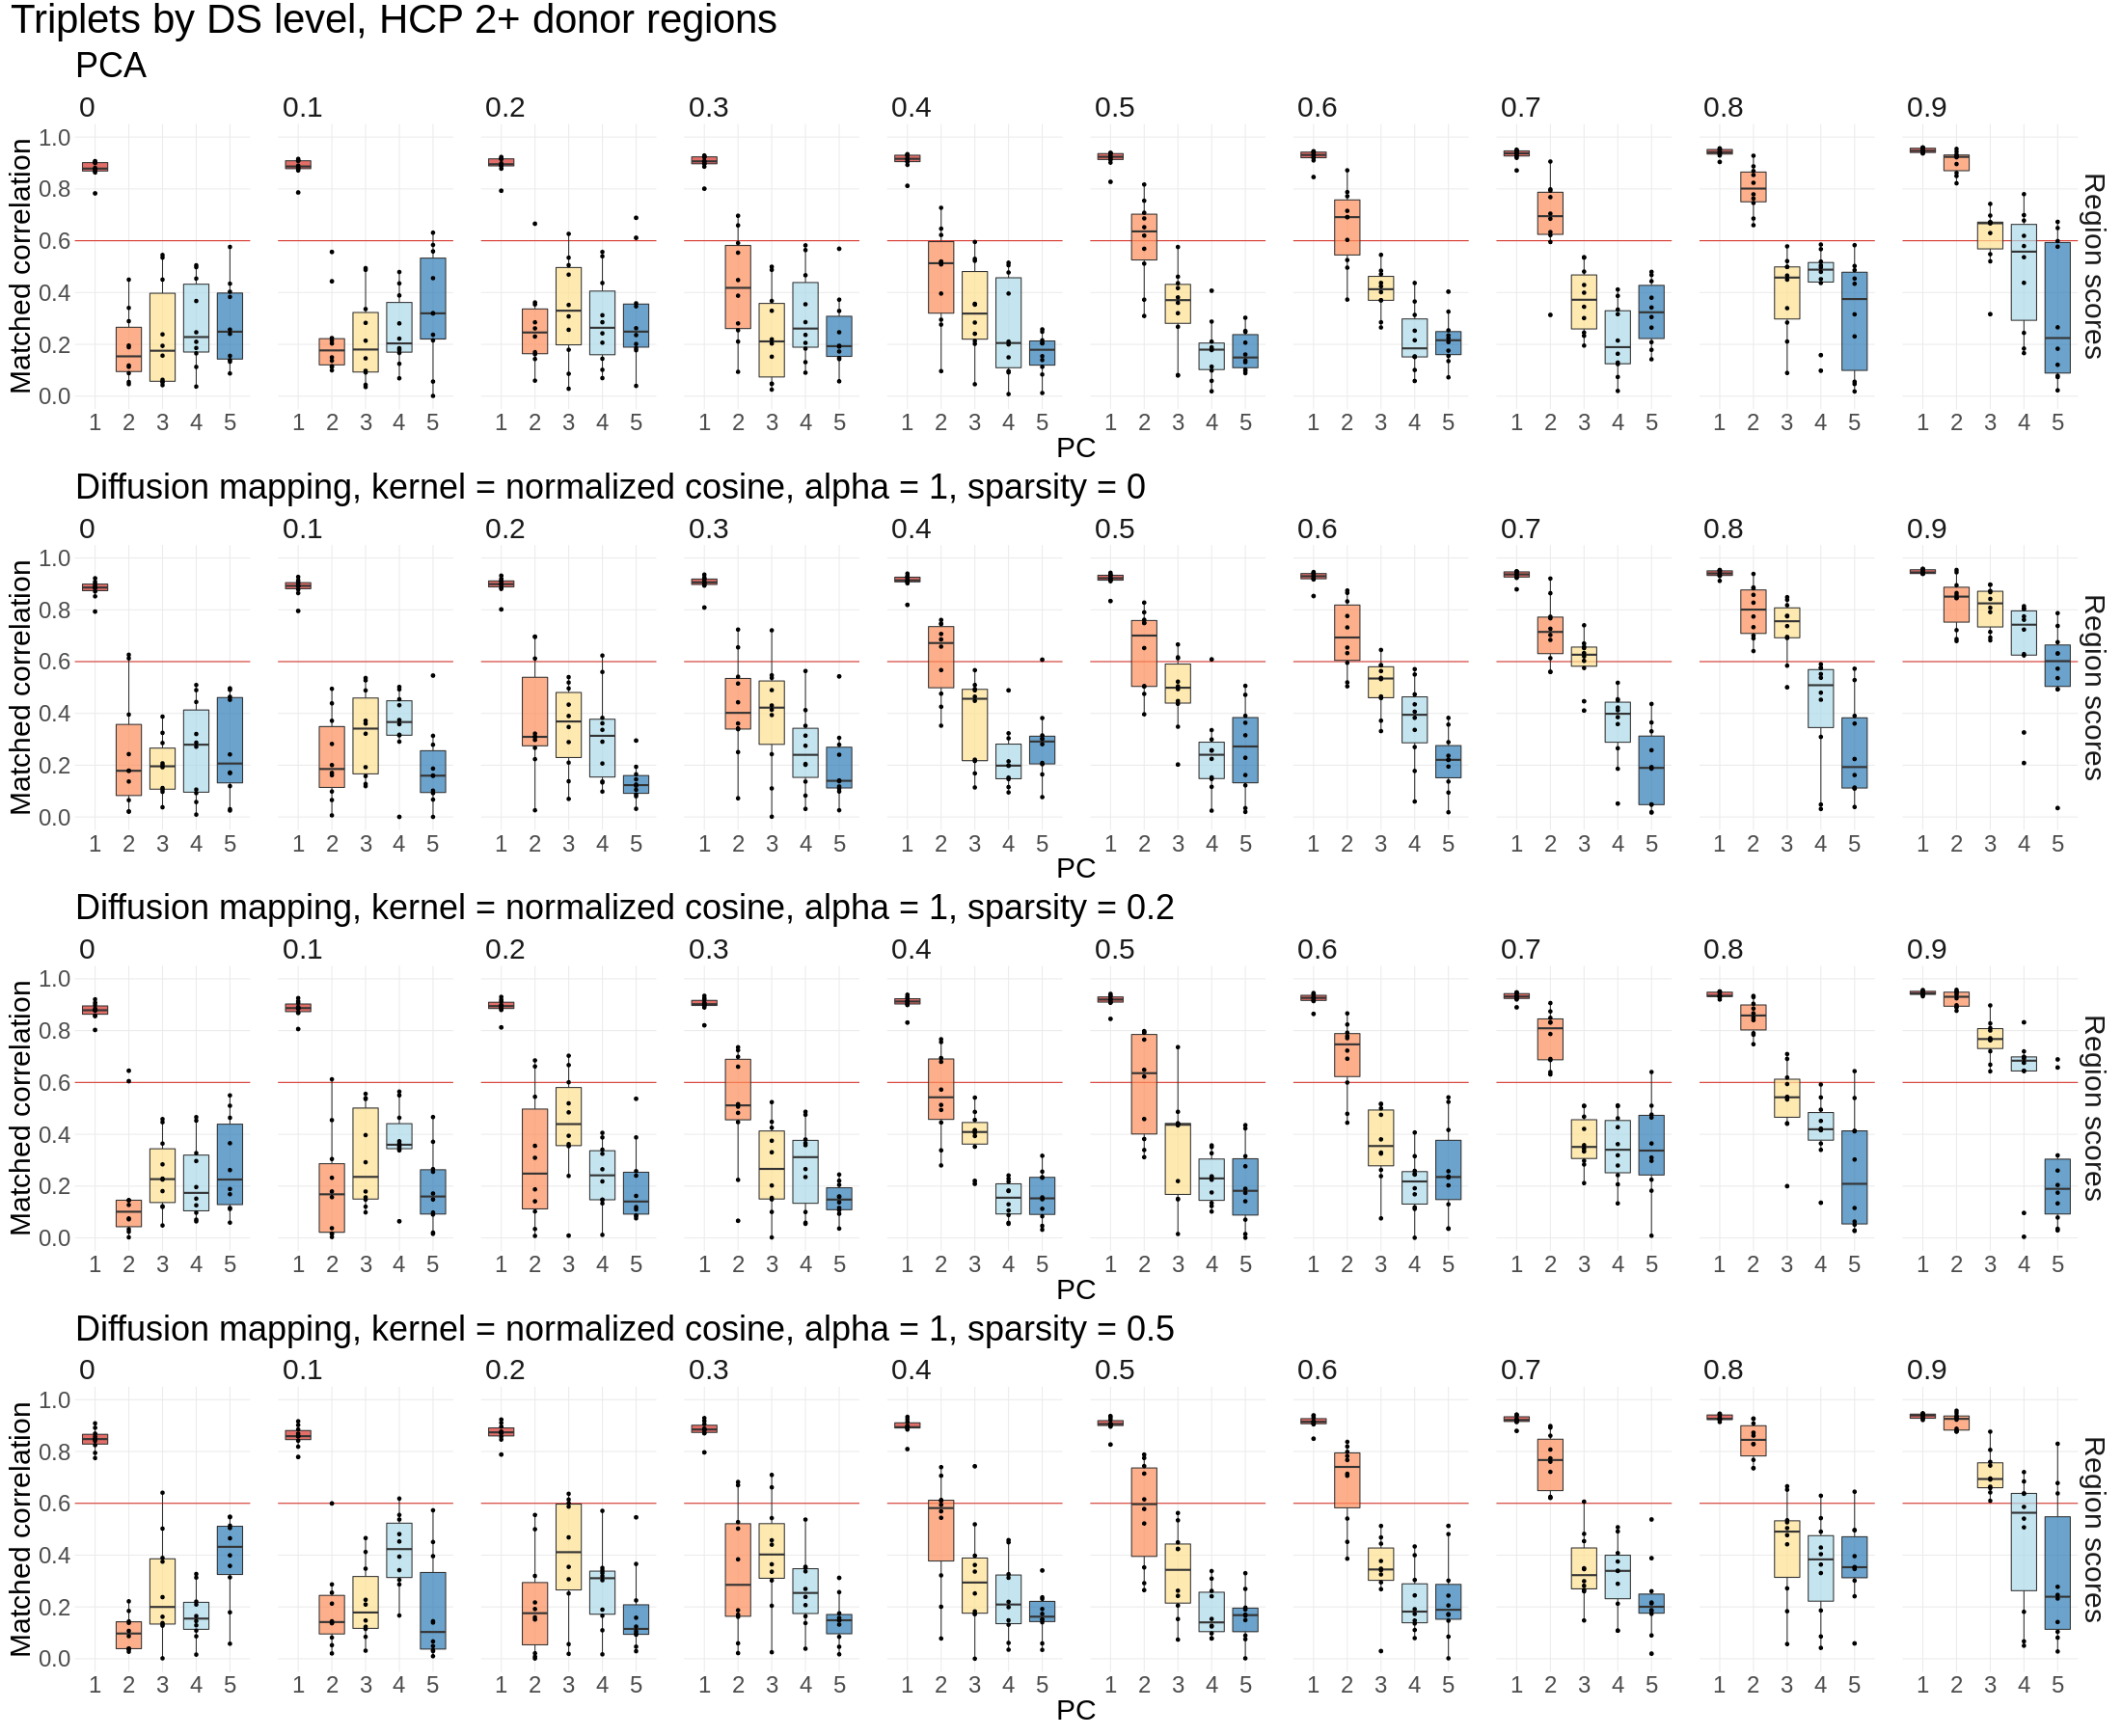

In [350]:
%%R -w 2200 -h 1800 -i pca_linear -i diffmap_sparse0 -i diffmap_sparse2 -i diffmap_sparse5
g1 <- plot_triplets(pca_linear) + ggtitle('PCA')
g2 <- plot_triplets(diffmap_sparse0) + ggtitle('Diffusion mapping, kernel = normalized cosine, alpha = 1, sparsity = 0') 
g3 <- plot_triplets(diffmap_sparse2) + ggtitle('Diffusion mapping, kernel = normalized cosine, alpha = 1, sparsity = 0.2') 
g4 <- plot_triplets(diffmap_sparse5) + ggtitle('Diffusion mapping, kernel = normalized cosine, alpha = 1, sparsity = 0.5')

((g1 / g2 / g3 / g4) & theme(text=element_text(size=30))) + 
plot_annotation(title='Triplets by DS level, HCP 2+ donor regions', theme = theme(plot.title = element_text(size = 42)))

---

# Plot the brains

In [360]:
hcp_ds9 = get_expression_abagen(atlas=fetch_hcp(), DS_threshold=0.9, donors_threshold=1, save_name='hcp_ds9')

1595 genes remain after filtering for top 0.1 differential stability


In [376]:
data_dir = "~/rds/rds-cam-psych-transc-Pb9UGUlrwWc/Cam_LIBD/AHBA_data/abagen-data/expression/"

hcp_3donors_ds5 = pd.read_csv(data_dir + 'hcp_3donors_ds5.csv', index_col=0)
hcp_3donors_ds6 = pd.read_csv(data_dir + 'hcp_3donors_ds6.csv', index_col=0)
hcp_2donors_ds8 = pd.read_csv(data_dir + 'hcp_2donors_ds8.csv', index_col=0)
hcp_3donors_ds8 = pd.read_csv(data_dir + 'hcp_3donors_ds8.csv', index_col=0)

hcp_3donors_ds9 = pd.read_csv(data_dir + 'hcp_3donors_ds9.csv', index_col=0)
hcp_2donors_ds9 = pd.read_csv(data_dir + 'hcp_2donors_ds9.csv', index_col=0)

pca_hcp_3d_ds9 = pcaVersion(hcp_3donors_ds9, scale=False)
dm_hcp_3d_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit(hcp_3donors_ds9)
dm_hcp_3d_ds5 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit(hcp_3donors_ds5)
dm_hcp_3d_ds6 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit(hcp_3donors_ds6)
dm_hcp_2d_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit(hcp_2donors_ds9)
dm_hcp_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit(hcp_ds9)
# hcp_3donors_ds8 = gradientVersion(approach='pca').fit(exp_3donors_ds8)
# hcp_3donors_ds8_dm = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit(exp_3donors_ds8)
# hcp_3donors_ds5_dm = gradientVersion(approach='dm', kernel='normalized_angle').fit(exp_3donors_ds5)
# hcp_3donors_ds6_dm = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit(exp_3donors_ds6)
# hcp_2donors_ds8 = gradientVersion(approach='pca').fit(exp_2donors_ds8)
# hcp_2donors_ds8_dm = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit(exp_2donors_ds8)

New PCA version
New gradients version: method=dm, sparsity=0, kernel=normalized_angle
New gradients version: method=dm, sparsity=0, kernel=normalized_angle
New gradients version: method=dm, sparsity=0, kernel=normalized_angle
New gradients version: method=dm, sparsity=0, kernel=normalized_angle
New gradients version: method=dm, sparsity=0, kernel=normalized_angle


In [384]:
def flip_scores(scores, ix_flip):
    scores_flip = scores.copy()
    scores_flip.iloc[:, ix_flip] *= -1
    return scores_flip

scores_dict = {
    'PCA 3+ donors DS 0.9': pca_hcp_3d_ds9.scores,
    'DM 3+ donors DS 0.5': dm_hcp_3d_ds5.scores.pipe(flip_scores, ix_flip=[3]),
    # 'DM 3+ donors DS 0.6': dm_hcp_3d_ds6.scores.pipe(flip_scores, ix_flip=[]),
    # 'DM 3+ donors DS 0.9': dm_hcp_3d_ds9.scores.pipe(flip_scores, ix_flip=[1]),
    # 'DM 2+ donors DS 0.9': dm_hcp_2d_ds9.scores.pipe(flip_scores, ix_flip=[1]),
    'DM DS 0.9': dm_hcp_ds9.scores.pipe(flip_scores, ix_flip=[1])
}

scores_df = (pd.concat(scores_dict)
             .groupby(level=0)
             .apply(lambda x: (x-np.mean(x))/np.std(x))
             .reset_index(level=0).rename({'level_0':'version'},axis=1)
             .join(get_labels_hcp())
                  )

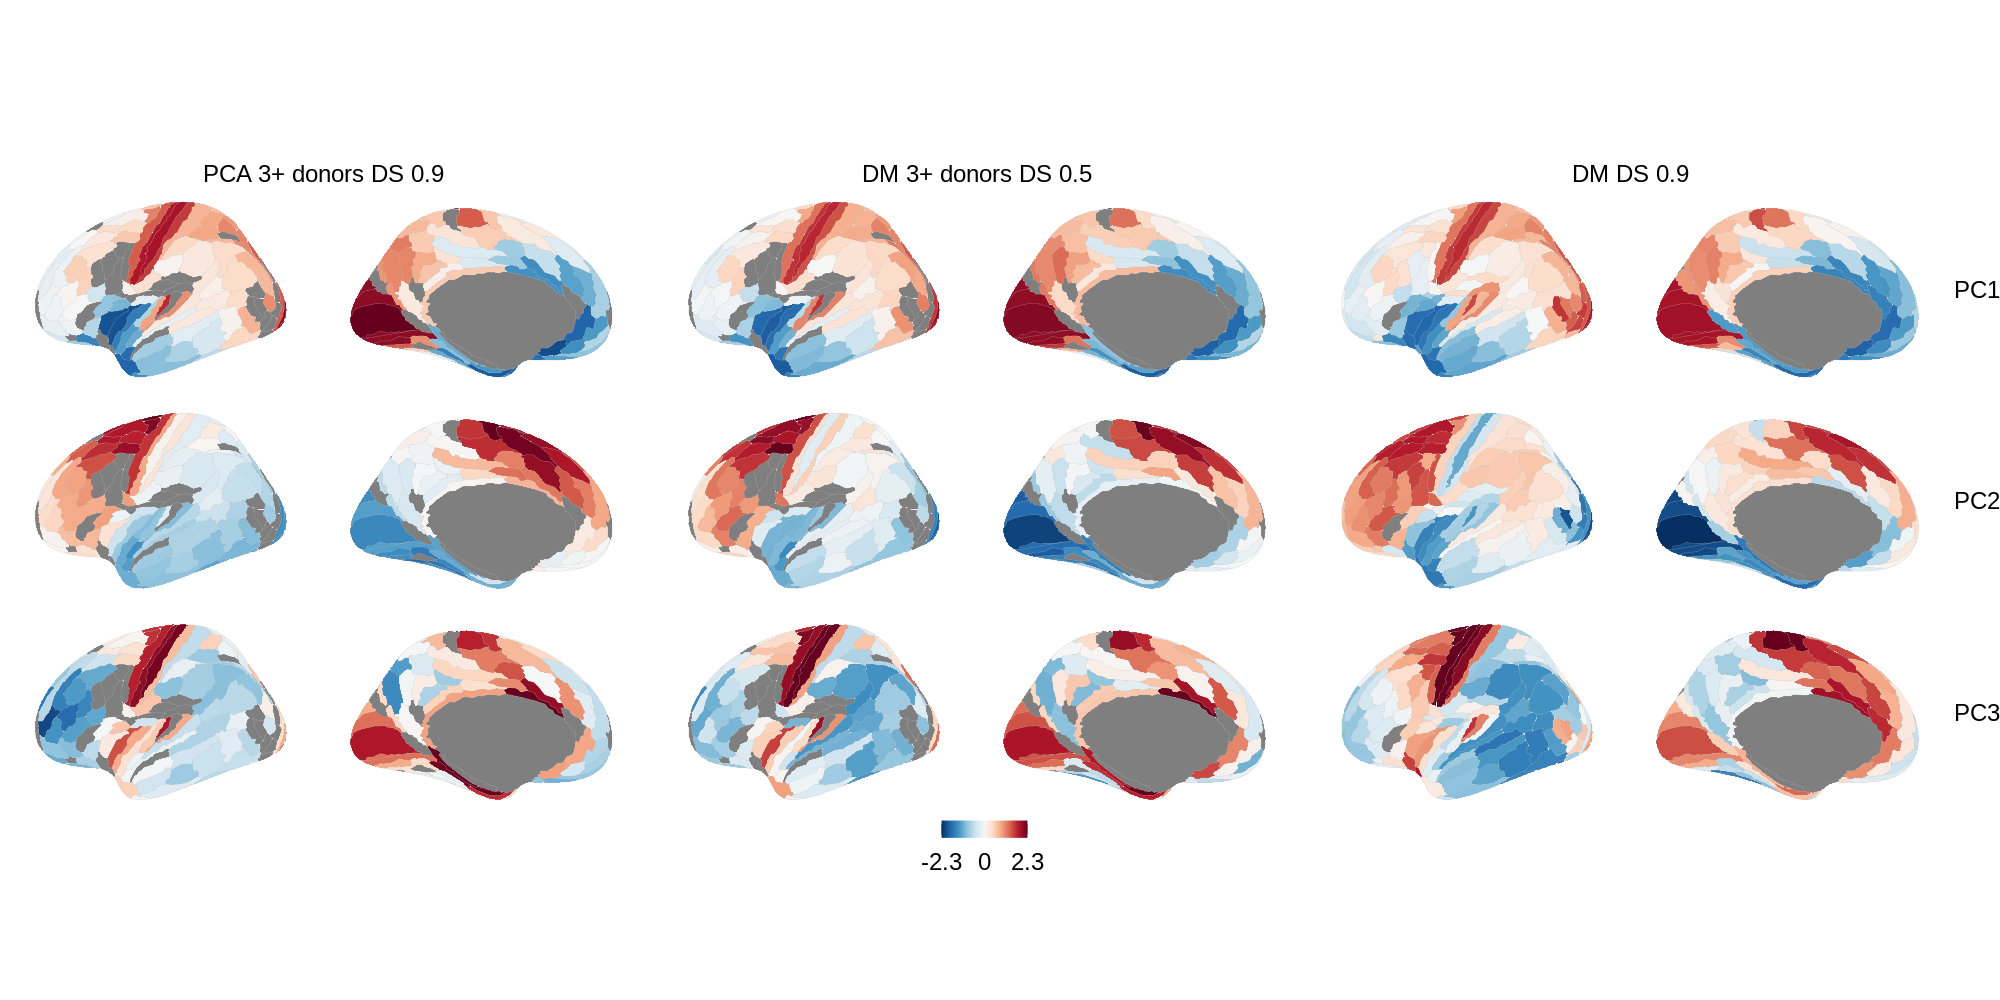

In [385]:
%%R -i scores_df -w 2000 -h 1000
source("../code/brainPlots.R")
plot_hcp(scores_df, three=T) + theme(text=element_text(size=30))

---

# New triplets plot idea

In [452]:
# pca = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp, use_gradientVersion=True, approach='pca'), with_coefs=False)
# dm = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp, use_gradientVersion=True, approach='dm', kernel='normalized_angle', alpha=1), with_coefs=False)
dm_2d = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp_2donors, use_gradientVersion=True, approach='dm', kernel='normalized_angle', alpha=1), with_coefs=False)
# dm_3d = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp_3donors, use_gradientVersion=True, approach='dm', kernel='normalized_angle', alpha=1), with_coefs=False)

In [454]:
triplets_dict = {
    'PCA':pca, 
    'Diffusion Map':dm,
    'Diffusion Map, 2+ donors/region':dm_2d,
    'Diffusion Map, 3+ donors/region':dm_3d
}

triplets_plot_v2 = (pd.concat(triplets_dict)
 .reset_index(0)
 .rename({'level_0':'method', 'version':'DS'}, axis=1)
 .assign(method = lambda x: pd.Categorical(x['method'], ordered=True, categories=triplets_dict.keys()))
                   )
triplets_plot_v2

method            how   DS component     pair  \
0                                PCA  Region scores  0.0         1  012-345   
1                                PCA  Region scores  0.0         2  012-345   
2                                PCA  Region scores  0.0         3  012-345   
3                                PCA  Region scores  0.0         4  012-345   
4                                PCA  Region scores  0.0         5  012-345   
..                               ...            ...  ...       ...      ...   
495  Diffusion Map, 3+ donors/region  Region scores  0.9         1  045-123   
496  Diffusion Map, 3+ donors/region  Region scores  0.9         2  045-123   
497  Diffusion Map, 3+ donors/region  Region scores  0.9         3  045-123   
498  Diffusion Map, 3+ donors/region  Region scores  0.9         4  045-123   
499  Diffusion Map, 3+ donors/region  Region scores  0.9         5  045-123   

         corr  corr_abs  
0    0.774335  0.774335  
1    0.041373  0.041373  
2    0.245817  0.245817  
3    0.106466  0.106466  
4   -0.107603  0.107603  
..        ...       ...  
495  0.971065  0.971065  
496  0.951726  0.951726  
497  0.931588  0.931588  
498  0.859526  0.859526  
499  0.865368  0.865368  

[2000 rows x 7 columns]

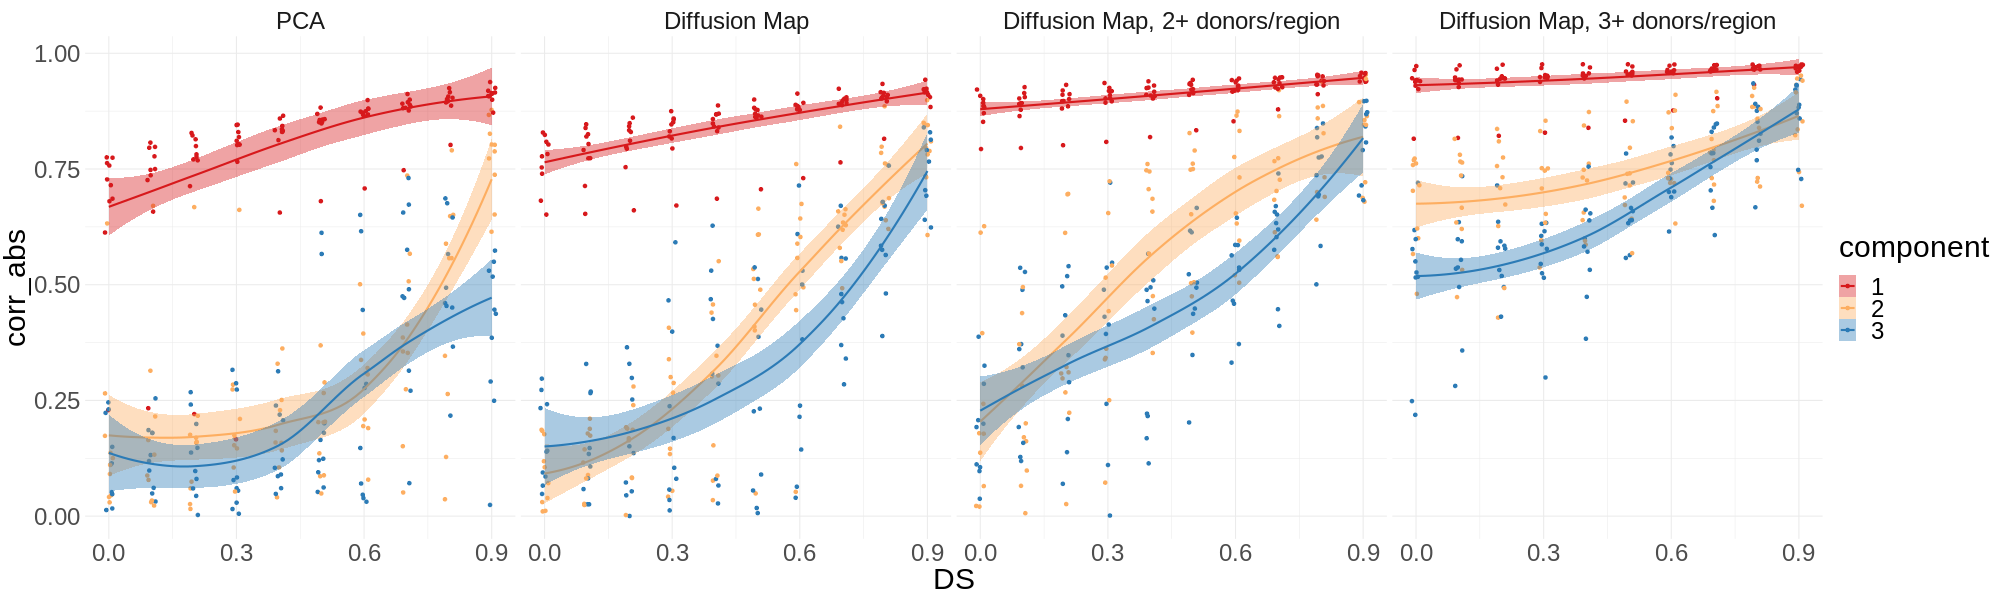

In [460]:
%%R -i triplets_plot_v2 -w 2000 -h 600
source("../code/Rplots.R")
plot_triplets_v2(triplets_plot_v2) & theme(text=element_text(size=30))

In [4]:
pca = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp_3donors, use_gradientVersion=True, approach='pca'), with_coefs=False)
dm = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp, use_gradientVersion=True, approach='dm', kernel='normalized_angle', alpha=1), with_coefs=False)
dm_2d = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp_2donors, use_gradientVersion=True, approach='dm', kernel='normalized_angle', alpha=1), with_coefs=False)
dm_3d = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp_3donors, use_gradientVersion=True, approach='dm', kernel='normalized_angle', alpha=1), with_coefs=False)

In [5]:
triplets_dict = {
    'PCA':pca, 
    'Diffusion Map':dm,
    'Diffusion Map, 2+ donors/region':dm_2d,
    'Diffusion Map, 3+ donors/region':dm_3d
}

triplets_plot_v2 = (pd.concat(triplets_dict)
 .reset_index(0)
 .rename({'level_0':'method', 'version':'DS'}, axis=1)
 .assign(method = lambda x: pd.Categorical(x['method'], ordered=True, categories=triplets_dict.keys()))
                   )
triplets_plot_v2

method            how   DS component     pair  \
0                                PCA  Region scores  0.0         1  012-345   
1                                PCA  Region scores  0.0         2  012-345   
2                                PCA  Region scores  0.0         3  012-345   
3                                PCA  Region scores  0.0         4  012-345   
4                                PCA  Region scores  0.0         5  012-345   
..                               ...            ...  ...       ...      ...   
495  Diffusion Map, 3+ donors/region  Region scores  0.9         1  045-123   
496  Diffusion Map, 3+ donors/region  Region scores  0.9         2  045-123   
497  Diffusion Map, 3+ donors/region  Region scores  0.9         3  045-123   
498  Diffusion Map, 3+ donors/region  Region scores  0.9         4  045-123   
499  Diffusion Map, 3+ donors/region  Region scores  0.9         5  045-123   

         corr  corr_abs  
0    0.952485  0.952485  
1    0.674435  0.674435  
2    0.057306  0.057306  
3   -0.563391  0.563391  
4    0.359771  0.359771  
..        ...       ...  
495  0.971192  0.971192  
496  0.951536  0.951536  
497  0.931963  0.931963  
498  0.859585  0.859585  
499  0.865362  0.865362  

[2000 rows x 7 columns]

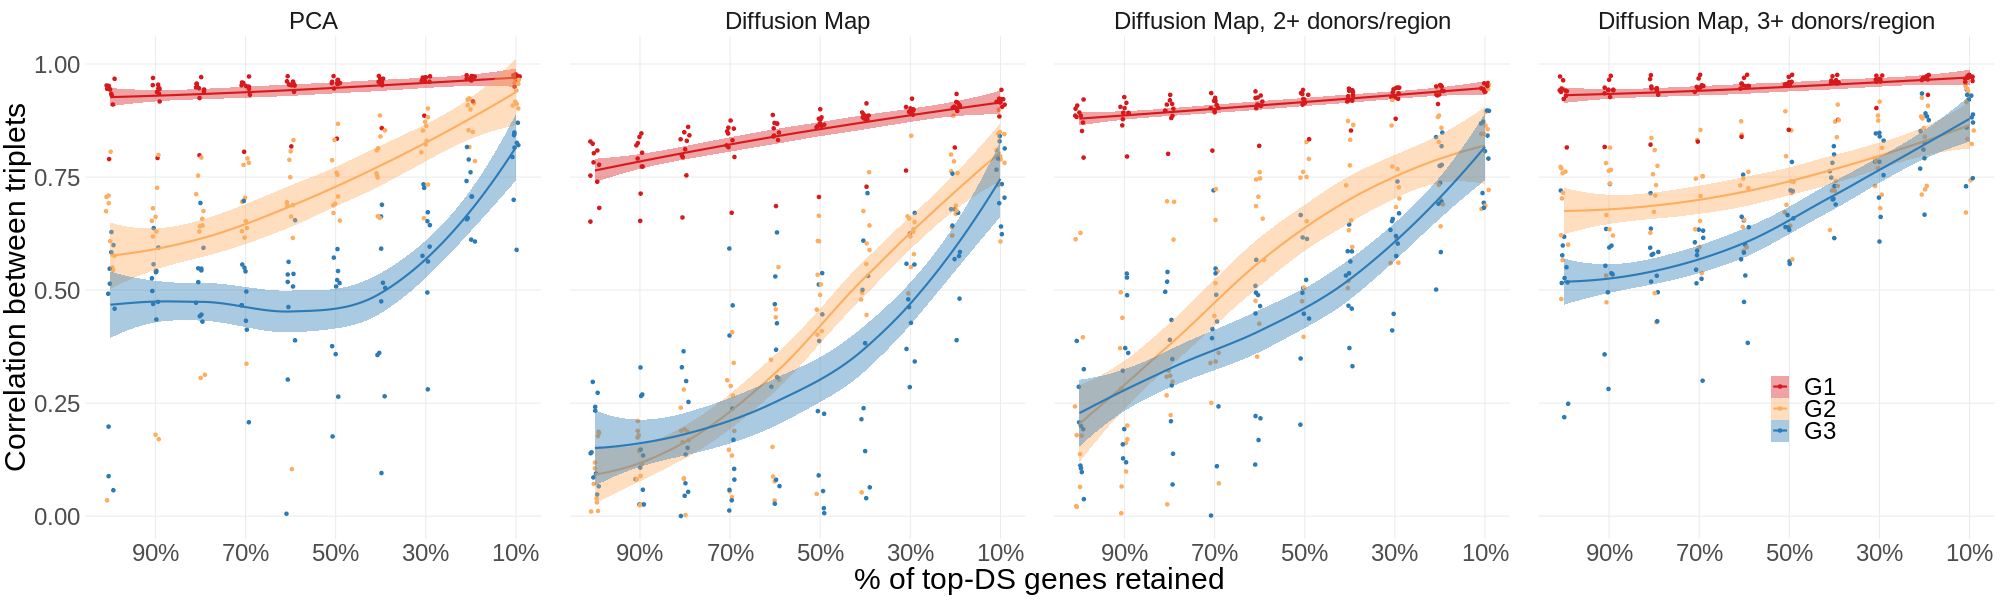

In [6]:
%%R -i triplets_plot_v2 -w 2000 -h 600
source("../code/Rplots.R")
plot_triplets_v2(triplets_plot_v2) & theme(text=element_text(size=30))

---

# DK

In [459]:
triplets_dk = get_triplets(atlas=fetch_dk())
# save_pickle(triplets_dk, 'triplets_dk')
triplets_dk = load_pickle('triplets_dk')

In [471]:
# pca_dk = make_triplet_ds_plot(get_triplets_ds_levels(triplets_dk, use_gradientVersion=True, approach='pca'), with_coefs=False)
# dm_dk = make_triplet_ds_plot(get_triplets_ds_levels(triplets_dk, use_gradientVersion=True, approach='dm', kernel='normalized_angle', alpha=1), with_coefs=False)

KeyboardInterrupt: 

In [472]:
triplets_dict = {
    'PCA':pca_dk, 
    'Diffusion Map':dm_dk,
}

triplets_plot_v2 = (pd.concat(triplets_dict)
 .reset_index(0)
 .rename({'level_0':'method', 'version':'DS'}, axis=1)
 .assign(method = lambda x: pd.Categorical(x['method'], ordered=True, categories=triplets_dict.keys()))
                   )
triplets_plot_v2

method            how   DS component     pair      corr  corr_abs
0              PCA  Region scores  0.0         1  012-345 -0.864963  0.864963
1              PCA  Region scores  0.0         2  012-345  0.661466  0.661466
2              PCA  Region scores  0.0         3  012-345  0.051352  0.051352
3              PCA  Region scores  0.0         4  012-345  0.269876  0.269876
4              PCA  Region scores  0.0         5  012-345 -0.571658  0.571658
..             ...            ...  ...       ...      ...       ...       ...
495  Diffusion Map  Region scores  0.9         1  045-123  0.980379  0.980379
496  Diffusion Map  Region scores  0.9         2  045-123  0.964172  0.964172
497  Diffusion Map  Region scores  0.9         3  045-123  0.901549  0.901549
498  Diffusion Map  Region scores  0.9         4  045-123  0.837228  0.837228
499  Diffusion Map  Region scores  0.9         5  045-123  0.760309  0.760309

[1000 rows x 7 columns]

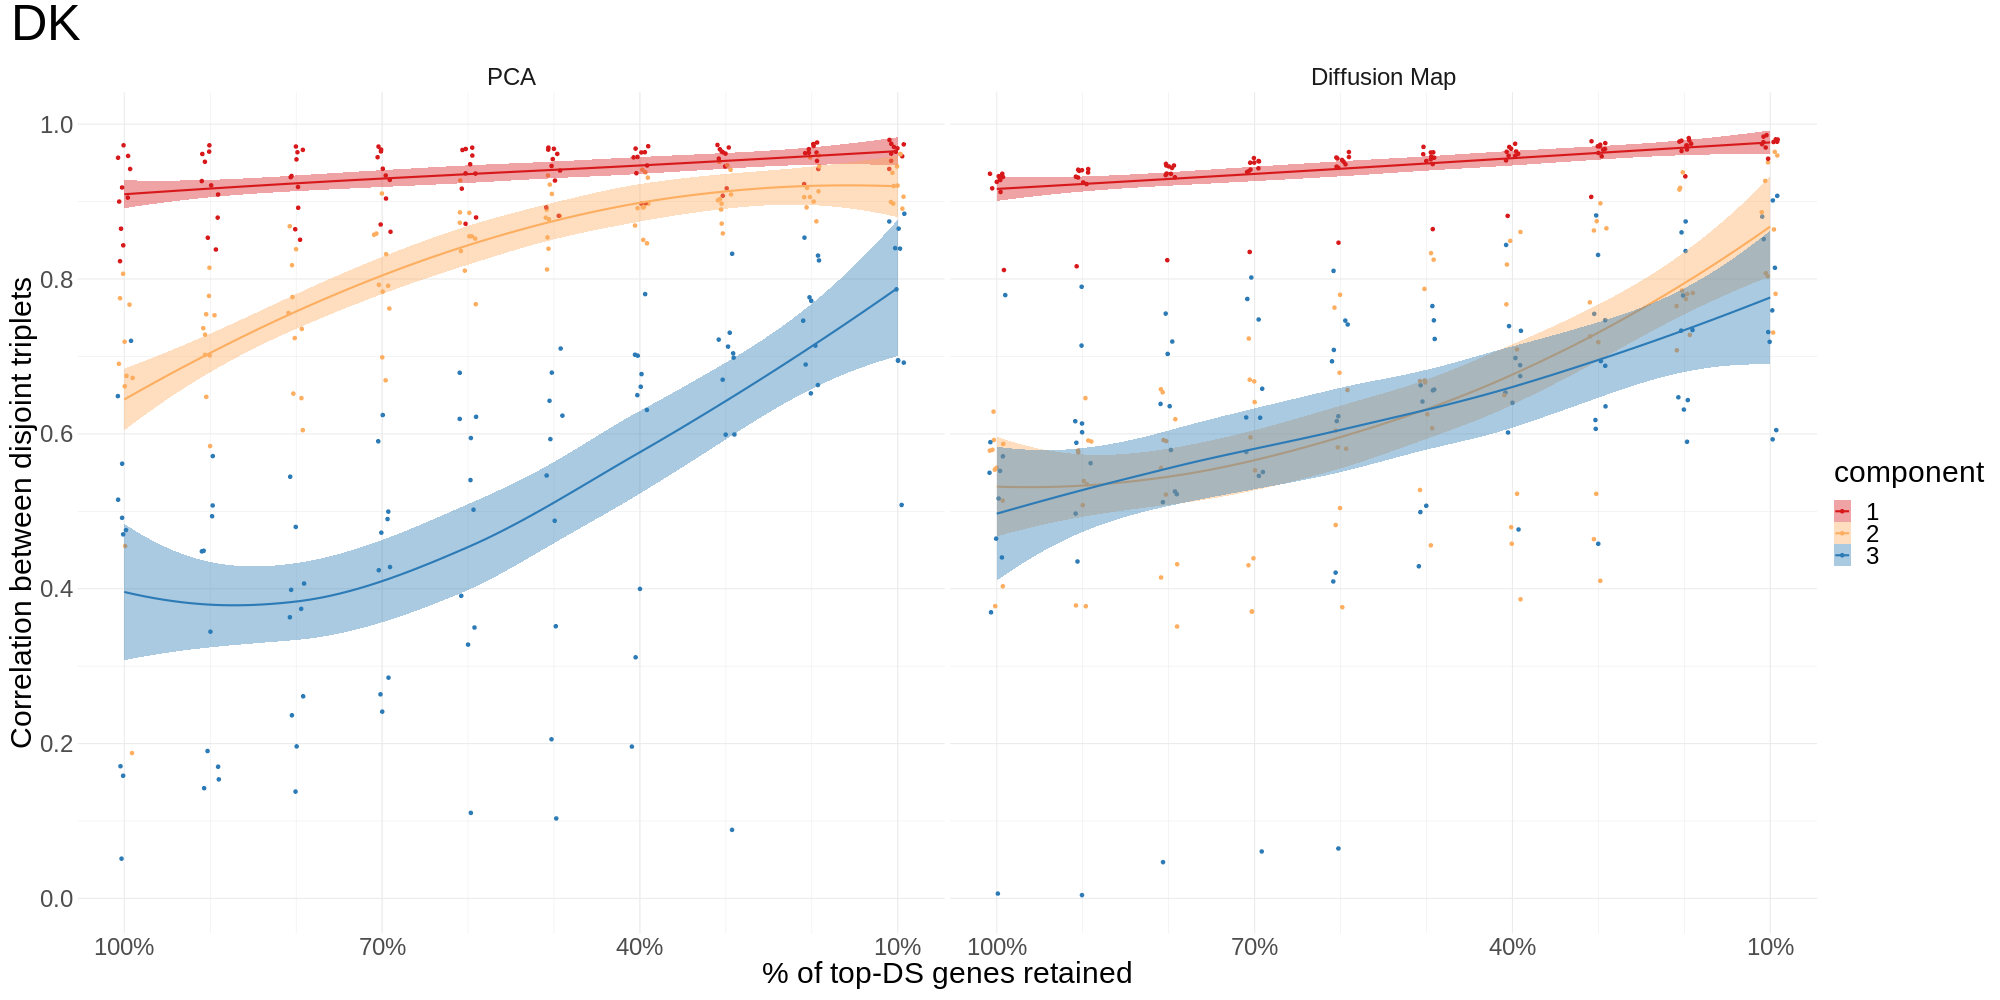

In [479]:
%%R -i triplets_plot_v2 -w 2000 -h 1000
source("../code/Rplots.R")
(
    plot_triplets_v2(triplets_plot_v2) & theme(text=element_text(size=30)) 
) + plot_annotation(title='DK', theme=theme(title=element_text(size=42)))

---

# Gene-PC region correlation vs coefs

In [217]:
gene_region_corrs = correlate(hcp_3donors_ds8.scores, hcp_3donors_ds8.expression)

In [264]:
coefs = (hcp_3donors_ds8.coefs.T
         .iloc[:,:3].set_axis(['PC1','PC2','PC3'],axis=1)
         .melt(ignore_index=False, var_name='PC', value_name='coef')
         .set_index('PC', append=True)
        )
corrs = (gene_region_corrs.T
         .iloc[:,:3].set_axis(['PC1','PC2','PC3'],axis=1)
         .melt(ignore_index=False, var_name='PC', value_name='corr')
         .set_index('PC', append=True)
        )

df_coef_corrs = coefs.join(corrs).reset_index()
df_coef_corrs.head()

level_0   PC      coef      corr
0    A1BG  PC1 -0.019914 -0.807991
1   ABCA6  PC1  0.017265  0.761945
2   ABCA9  PC1  0.016686  0.738792
3  ABCC12  PC1 -0.005588 -0.237055
4   ABCC5  PC1  0.007686  0.359591

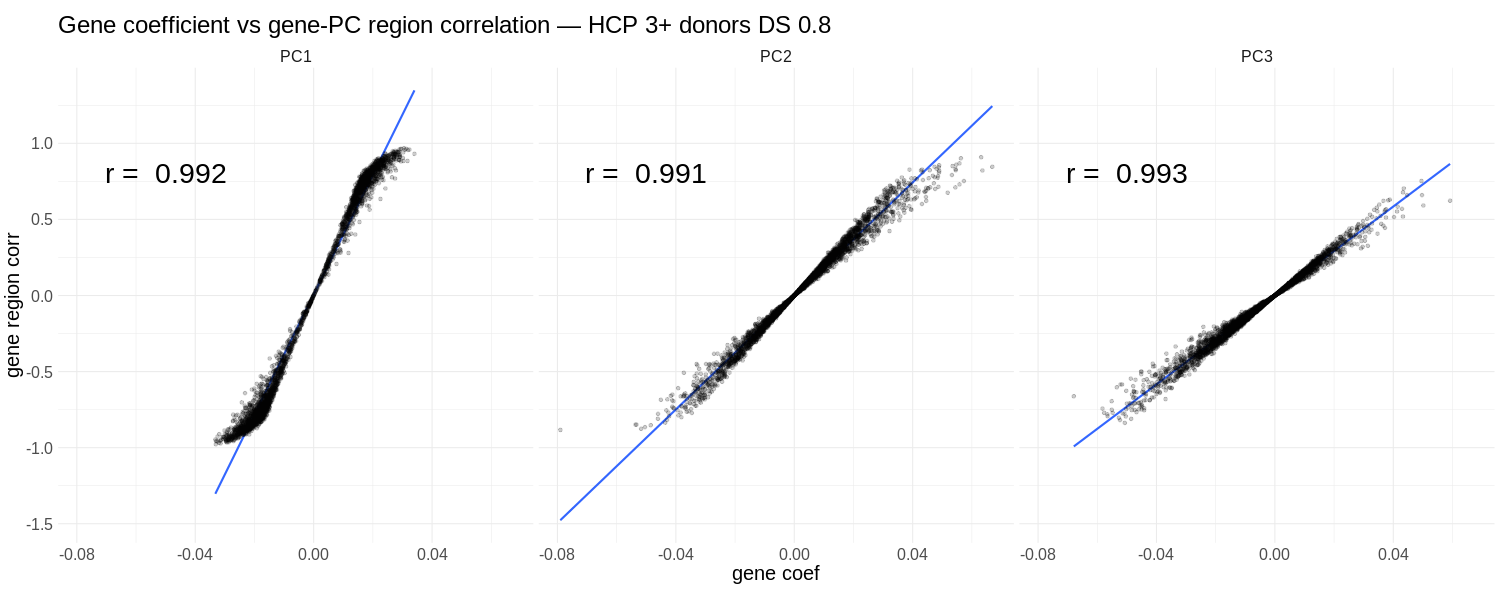

In [277]:
%%R -i df_coef_corrs -w 1500 -h 600

r = df_coef_corrs %>% group_by(PC) %>% summarize(r=cor(coef, corr))

ggplot(df_coef_corrs, aes(coef, corr)) + 
facet_wrap(~PC) +
geom_smooth(method='lm') +
geom_point(alpha=.2) + 
geom_text(data=r, aes(x=-.05, y=.8, label=paste('r = ', round(r,3))), size=10) +
labs(x='gene coef', y='gene region corr') +
ggtitle('Gene coefficient vs gene-PC region correlation — HCP 3+ donors DS 0.8') +
theme_minimal() + 
theme(aspect.ratio=1, text=element_text(size=20))

## Can we recover DM maps by using the gene correlations as if they were PC weights?

In [298]:
gene_region_corrs = correlate(hcp_2donors_ds8_dm.scores, hcp_2donors_ds8_dm.expression)

In [312]:
scores_projected = (exp_2donors_ds8 @ gene_region_corrs.T).dropna()
scores_dict = {
    'DM 2+ donors DS 0.8': hcp_2donors_ds8_dm.scores.pipe(flip_scores, ix_flip=1),
    'Proejct gene-region corrs as linear weights': scores_projected.pipe(flip_scores, ix_flip=1)
}

scores_df = (pd.concat(scores_dict)
             .groupby(level=0)
             .apply(lambda x: (x-np.mean(x))/np.std(x))
             .reset_index(level=0).rename({'level_0':'version'},axis=1)
             .join(get_labels_hcp())
                  )

In [313]:
scores_projected.corrwith(hcp_2donors_ds8_dm.scores)

0    0.995357
1    0.952210
2    0.910608
3    0.856906
4    0.771312
dtype: float64

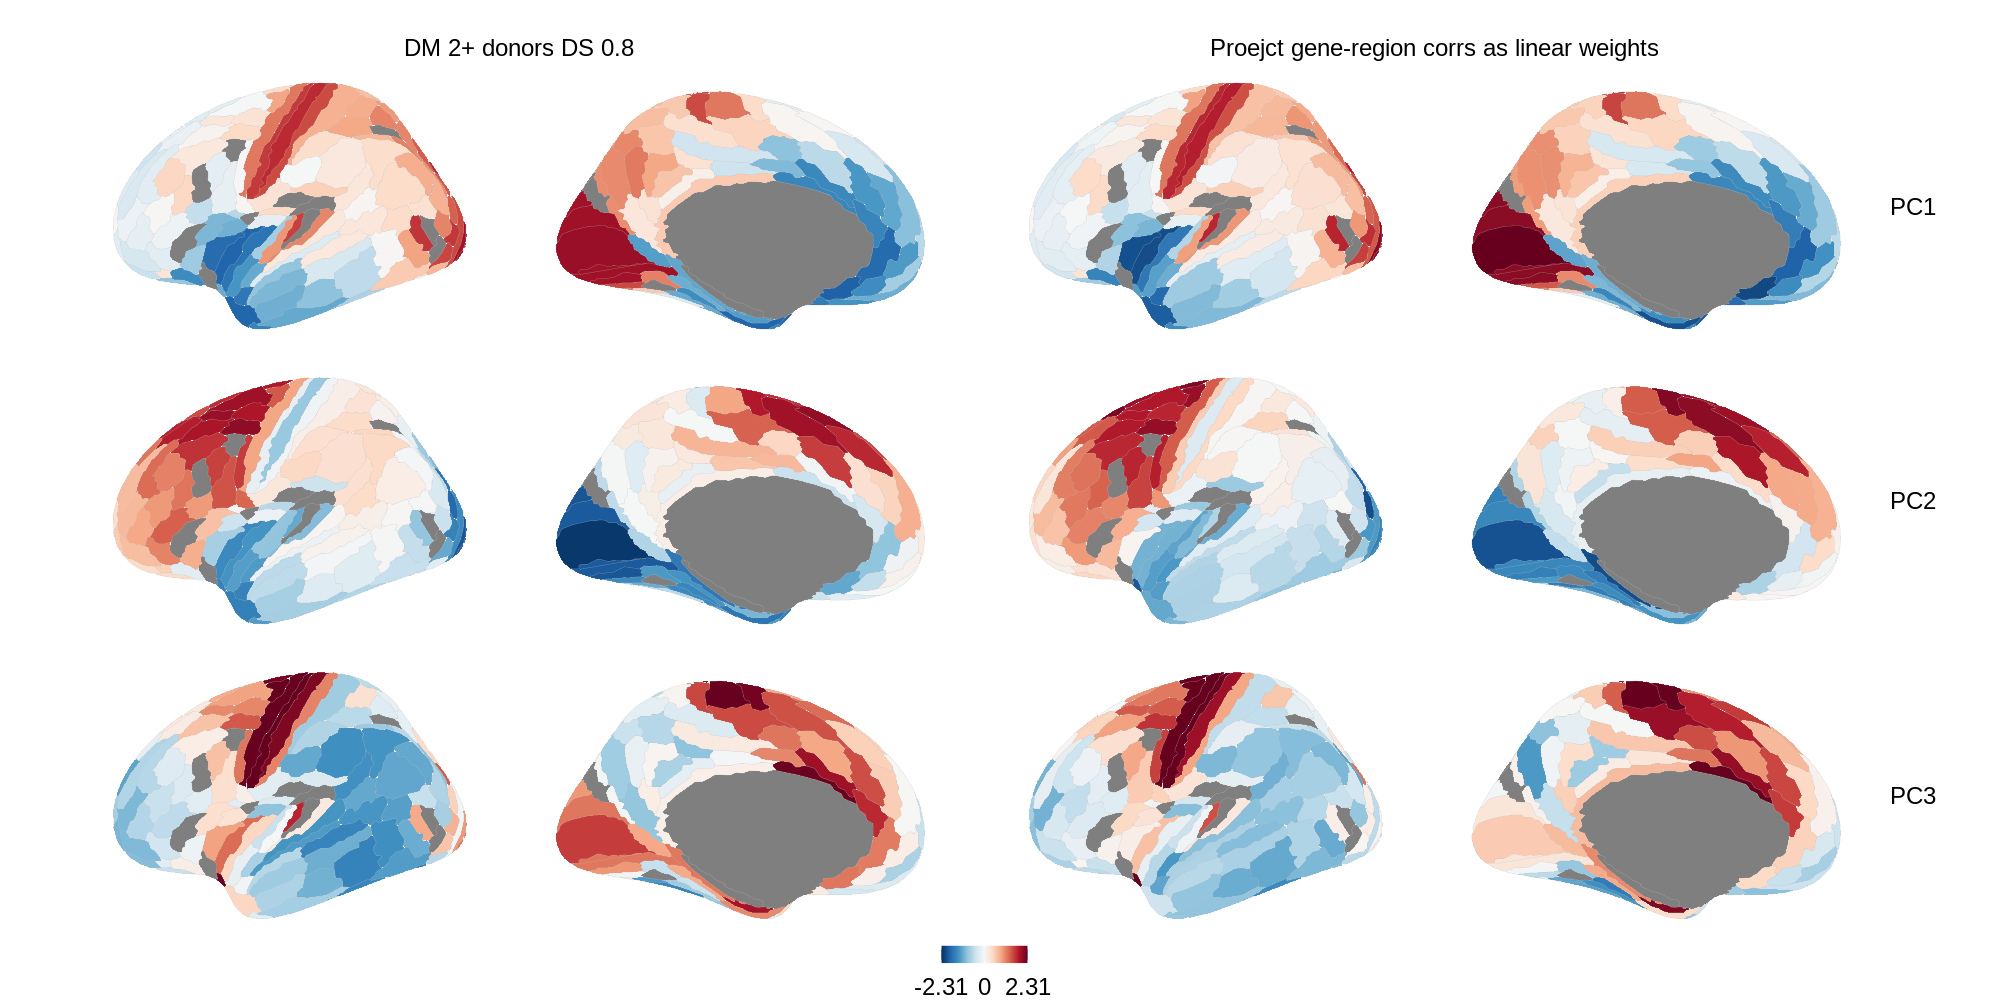

In [314]:
%%R -i scores_df -w 2000 -h 1000
plot_hcp(scores_df, three=T) + theme(text=element_text(size=30))

## Check enrichments

In [325]:
hcp_2donors_ds8_dm.correlate_genes(
    hcp_2donors_ds8_dm.expression, return_ranks=True
).to_csv("../outputs/gene_weights_dm_2donors_ds8.csv")

In [ ]:
hcp_2donors_ds8_dm.correlate_genes(
    exp_2donors, return_ranks=True
).to_csv("../outputs/gene_weights_dm_2donors_ds8_all.csv")

---

# DK

In [28]:
triplets_ds_levels_dk = {}
for ds in [i/10 for i in range(0,10)]:
     triplets_ds_levels_dk[ds] = filter_triplet_ds(triplets_dk, ds)

In [29]:
coefs_dict = {name:disjoint_corrs(t) for name, t in triplets_ds_levels_dk.items()}
scores_dict = {name:disjoint_corrs(t, how='scores') for name, t in triplets_ds_levels_dk.items()}

triplet_versions = (
    pd.concat({'Gene weights': pd.concat(coefs_dict), 'Region scores': pd.concat(scores_dict)})
    .reset_index()
    .rename(columns={'level_0':'how', 'level_1':'version', 'level_2':'component'})
    .assign(component=lambda x: x['component'].replace({i:f'{i+1}' for i in range(5)}))
    .melt(id_vars=['how', 'version', 'component'], var_name='pair', value_name='corr')
    .assign(corr_abs = lambda x: np.abs(x['corr']))
    # .assign(version = lambda x: pd.Categorical(x['version'], categories=x['version'].unique(),ordered=True))
)

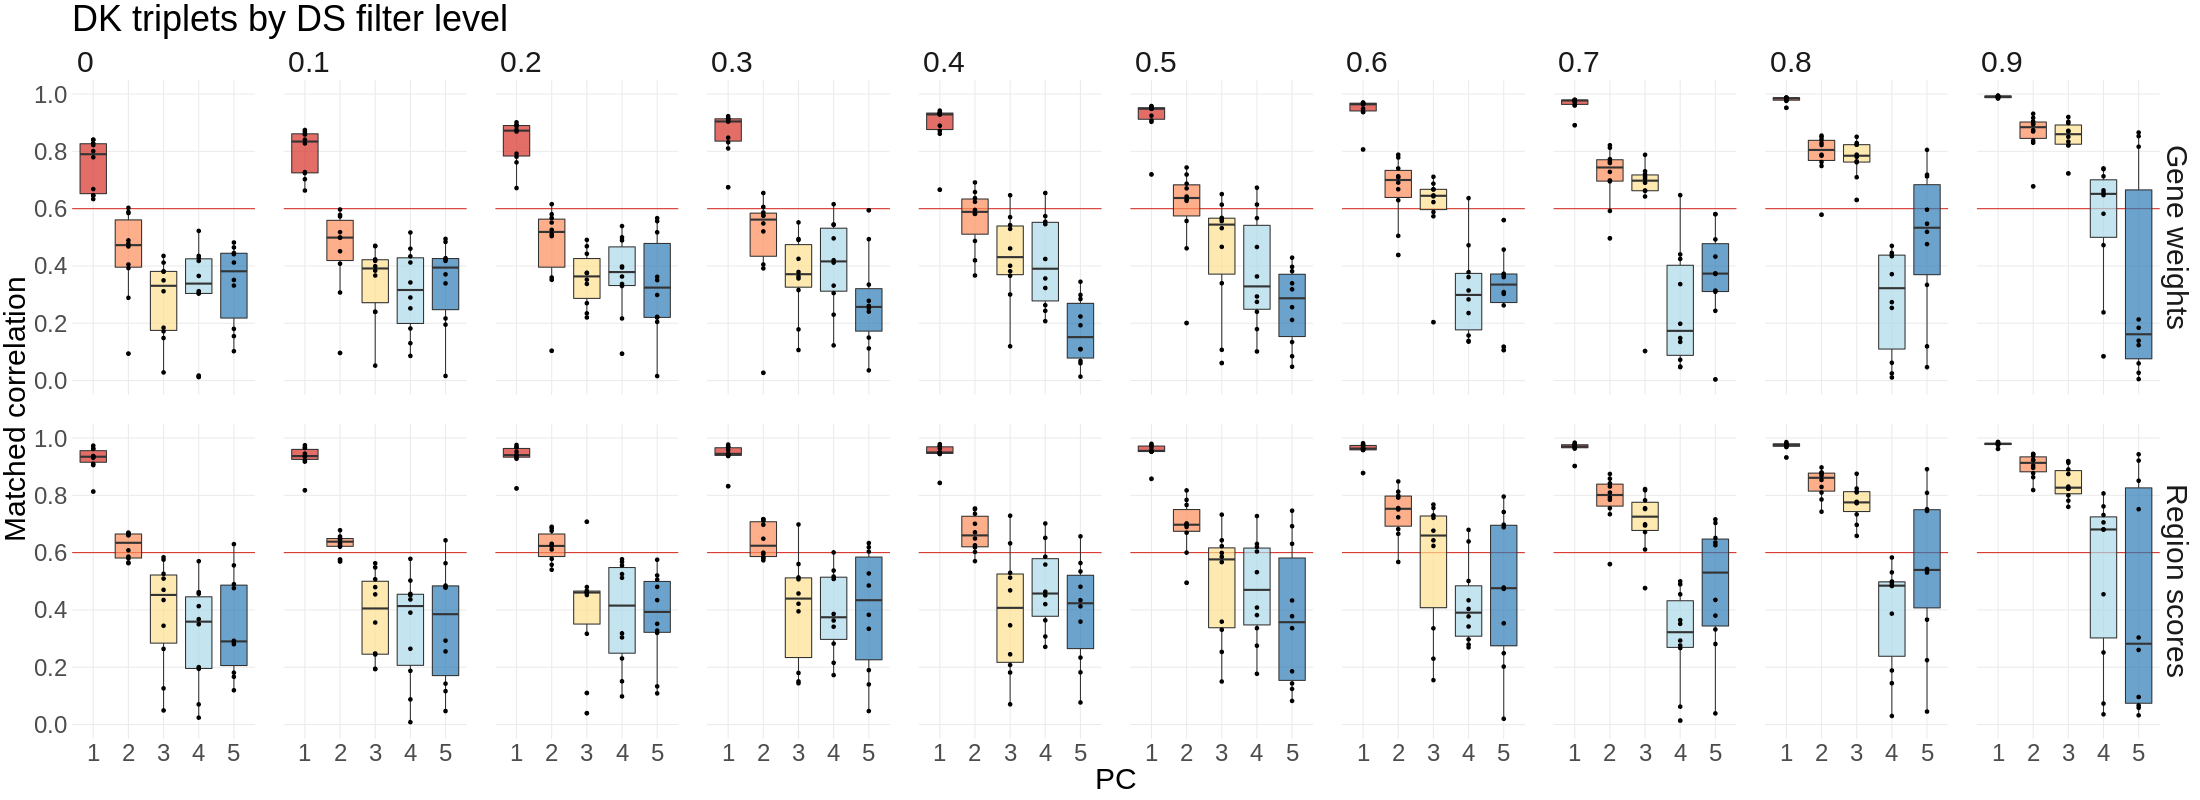

In [30]:
%%R -w 2200 -h 800 -i triplet_versions
source("../code/Rplots.R")
plot_triplets(triplet_versions) + ggtitle('DK triplets by DS filter level') & theme(text=element_text(size=30))

---

In [85]:
triplets_ds_levels_brain = {}
for ds in [i/10 for i in range(0,10)]:
     triplets_ds_levels_brain[ds] = filter_triplet_ds(triplets_hcp_3donors, ds, only_brain=True)

In [86]:
coefs_dict = {name:disjoint_corrs(t) for name, t in triplets_ds_levels_brain.items()}
scores_dict = {name:disjoint_corrs(t, how='scores') for name, t in triplets_ds_levels_brain.items()}

triplet_versions = (
    pd.concat({'Gene weights': pd.concat(coefs_dict), 'Region scores': pd.concat(scores_dict)})
    .reset_index()
    .rename(columns={'level_0':'how', 'level_1':'version', 'level_2':'component'})
    .assign(component=lambda x: x['component'].replace({i:f'{i+1}' for i in range(5)}))
    .melt(id_vars=['how', 'version', 'component'], var_name='pair', value_name='corr')
    .assign(corr_abs = lambda x: np.abs(x['corr']))
    # .assign(version = lambda x: pd.Categorical(x['version'], categories=x['version'].unique(),ordered=True))
)

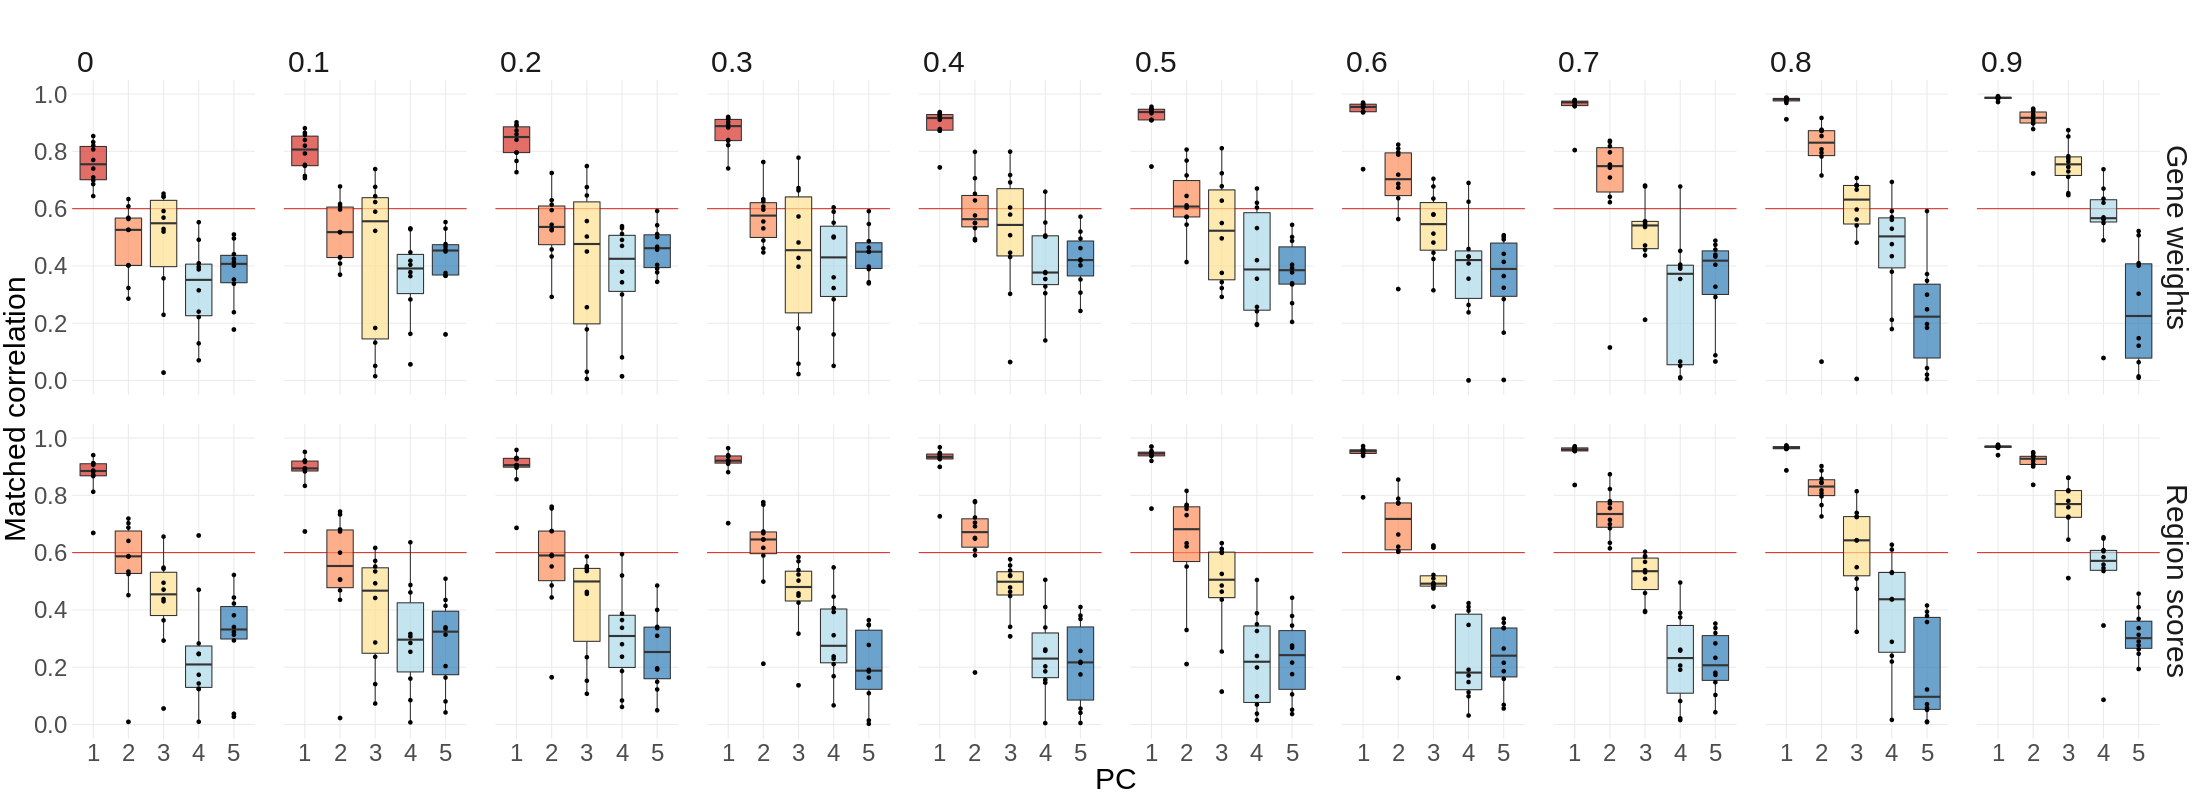

In [87]:
%%R -w 2200 -h 800 -i triplet_versions
source("../code/Rplots.R")
plot_triplets(triplet_versions) & theme(text=element_text(size=30))

---

In [80]:
def save_pickle(data, fname):
    with open('../outputs/' + fname + '.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
# save_pickle(triplets_hcp, 'triplets_hcp')
save_pickle(triplets_3donors_hcp, 'triplets_3donors_hcp')
save_pickle(triplets_3donors_hcp_native, 'triplets_3donors_hcp_native')

In [78]:
def load_pickle(fname):
    with open('../outputs/' + fname + '.pickle', 'rb') as handle:
        return pickle.load(handle)

triplets_hcp = load_pickle('triplets_hcp')

In [69]:
triplets_hcp = {}
for name, donors in triplets_dict_donors.items():
    expression, stability = get_expression_abagen(fetch_hcp(native=False), donors=donors,
        probe_selection='diff_stability', region_agg='donors',
        lr_mirror='rightleft', #donors_threshold=3, 
        return_stability=True
    )
    triplets_hcp[name] = pcaVersion(expression, message=False)
    triplets_hcp[name].stability = stability

15666 genes remain after filtering for top 1 differential stability
15703 genes remain after filtering for top 1 differential stability
15861 genes remain after filtering for top 1 differential stability
15927 genes remain after filtering for top 1 differential stability
15568 genes remain after filtering for top 1 differential stability
15730 genes remain after filtering for top 1 differential stability
15803 genes remain after filtering for top 1 differential stability
15759 genes remain after filtering for top 1 differential stability
15838 genes remain after filtering for top 1 differential stability
16039 genes remain after filtering for top 1 differential stability
15789 genes remain after filtering for top 1 differential stability
16027 genes remain after filtering for top 1 differential stability
16118 genes remain after filtering for top 1 differential stability
15992 genes remain after filtering for top 1 differential stability
16074 genes remain after filtering for top 1 dif

In [9]:
triplets_3donors_hcp = {}
for name, donors in triplets_dict_donors.items():
    expression, stability = get_expression_abagen(fetch_hcp(native=False), donors=donors,
        probe_selection='diff_stability', region_agg='donors',
        donors_threshold=3, lr_mirror='rightleft',
        return_stability=True
    )
    triplets_3donors_hcp[name] = pcaVersion(expression, message=False)
    triplets_3donors_hcp[name].stability = stability

15666 genes remain after filtering for top 1 differential stability
15703 genes remain after filtering for top 1 differential stability
15861 genes remain after filtering for top 1 differential stability
15927 genes remain after filtering for top 1 differential stability
15568 genes remain after filtering for top 1 differential stability
15730 genes remain after filtering for top 1 differential stability
15803 genes remain after filtering for top 1 differential stability
15759 genes remain after filtering for top 1 differential stability
15838 genes remain after filtering for top 1 differential stability
16039 genes remain after filtering for top 1 differential stability
15789 genes remain after filtering for top 1 differential stability
16027 genes remain after filtering for top 1 differential stability
16118 genes remain after filtering for top 1 differential stability
15992 genes remain after filtering for top 1 differential stability
16074 genes remain after filtering for top 1 dif

In [52]:
triplets_3donors_hcp_native = {}
for name, donors in triplets_dict_donors.items():
    expression, stability = get_expression_abagen(fetch_hcp(native=True), donors=donors,
        probe_selection='diff_stability', region_agg='donors',
        donors_threshold=3, lr_mirror='rightleft',
        return_stability=True
    )
    triplets_3donors_hcp_native[name] = pcaVersion(expression, message=False)
    triplets_3donors_hcp_native[name].stability = stability

15665 genes remain after filtering for top 1 differential stability
15701 genes remain after filtering for top 1 differential stability
15861 genes remain after filtering for top 1 differential stability
15926 genes remain after filtering for top 1 differential stability
15564 genes remain after filtering for top 1 differential stability
15728 genes remain after filtering for top 1 differential stability
15803 genes remain after filtering for top 1 differential stability
15755 genes remain after filtering for top 1 differential stability
15836 genes remain after filtering for top 1 differential stability
16039 genes remain after filtering for top 1 differential stability
15787 genes remain after filtering for top 1 differential stability
16027 genes remain after filtering for top 1 differential stability
16120 genes remain after filtering for top 1 differential stability
15992 genes remain after filtering for top 1 differential stability
16075 genes remain after filtering for top 1 dif

In [20]:
def filter_triplet_ds(triplets, ds_threshold=0):
    triplets_ds = {}
    for name, triplet in triplets.items():
        mask = triplet.stability.rank(pct=True) > ds_threshold
        triplet_expression_ds = triplet.expression.loc[:, mask]
        triplets_ds[name] = pcaVersion(triplet_expression_ds, message=False)
    return triplets_ds

triplets_3donors_hcp_ds8 = filter_triplet_ds(triplets_3donors_hcp, 0.8)

Compare MNI and Native triplets across DS levels

In [100]:
triplets_ds_levels = {}
for ds in [i/10 for i in range(0,10)]:
     triplets_ds_levels[ds] = filter_triplet_ds(triplets_hcp, ds)

In [99]:
# triplets_ds_levels_3donors = triplets_ds_levels
# triplets_ds_levels_native = triplets_ds_levels

In [85]:
data_dir = "~/rds/rds-cam-psych-transc-Pb9UGUlrwWc/Cam_LIBD/AHBA_data/abagen-data/expression/"
hcp_base = pcaVersion(pd.read_csv(data_dir + 'hcp_base.csv', index_col=0))

New PCA version


In [109]:
base = None
# base = hcp_base
match = True

coefs_dict = {name:disjoint_corrs(t, base=base, match=match) for name, t in triplets_ds_levels.items()}
scores_dict = {name:disjoint_corrs(t, base=base, match=match, how='scores') for name, t in triplets_ds_levels.items()}

triplet_versions = (
    pd.concat({'Gene weights': pd.concat(coefs_dict), 'Region scores': pd.concat(scores_dict)})
    .reset_index()
    .rename(columns={'level_0':'how', 'level_1':'version', 'level_2':'component'})
    .assign(component=lambda x: x['component'].replace({i:f'{i+1}' for i in range(5)}))
    .melt(id_vars=['how', 'version', 'component'], var_name='pair', value_name='corr')
    .assign(corr_abs = lambda x: np.abs(x['corr']))
    # .assign(version = lambda x: pd.Categorical(x['version'], categories=x['version'].unique(),ordered=True))
)

MNI

DS levels, no donor filter

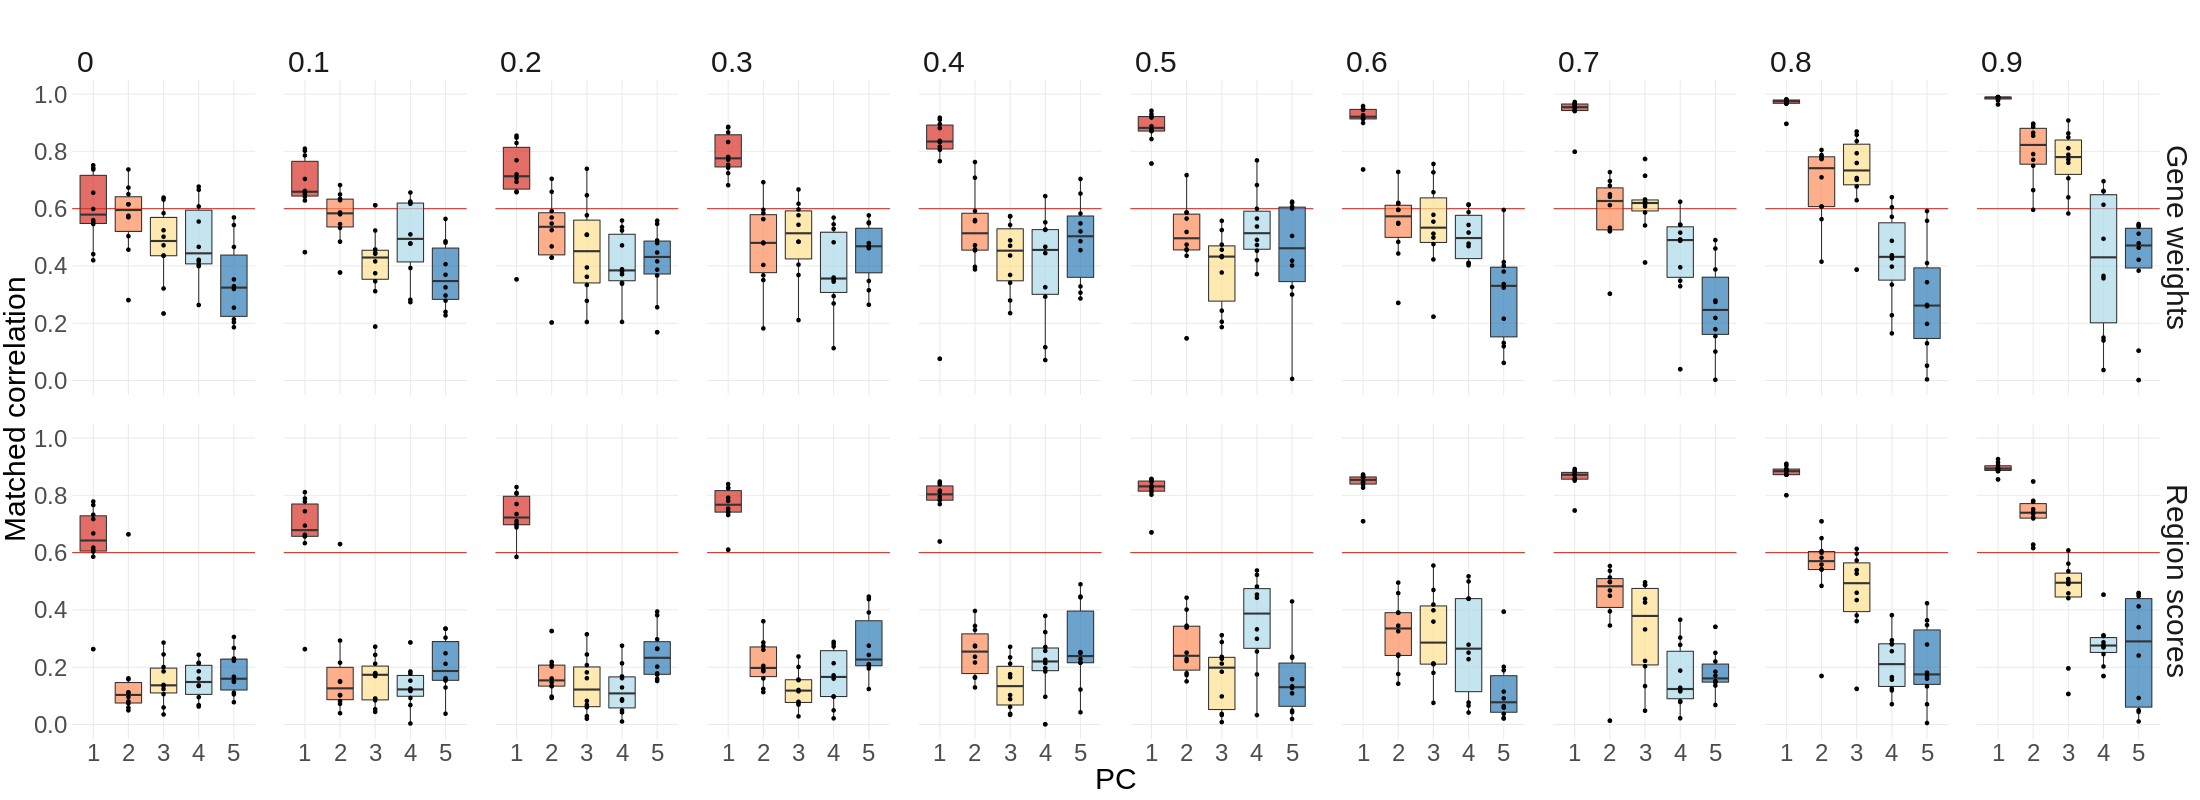

In [110]:
%%R -w 2200 -h 800 -i triplet_versions
source("../code/Rplots.R")
plot_triplets(triplet_versions) & theme(text=element_text(size=30))

3 donor filter

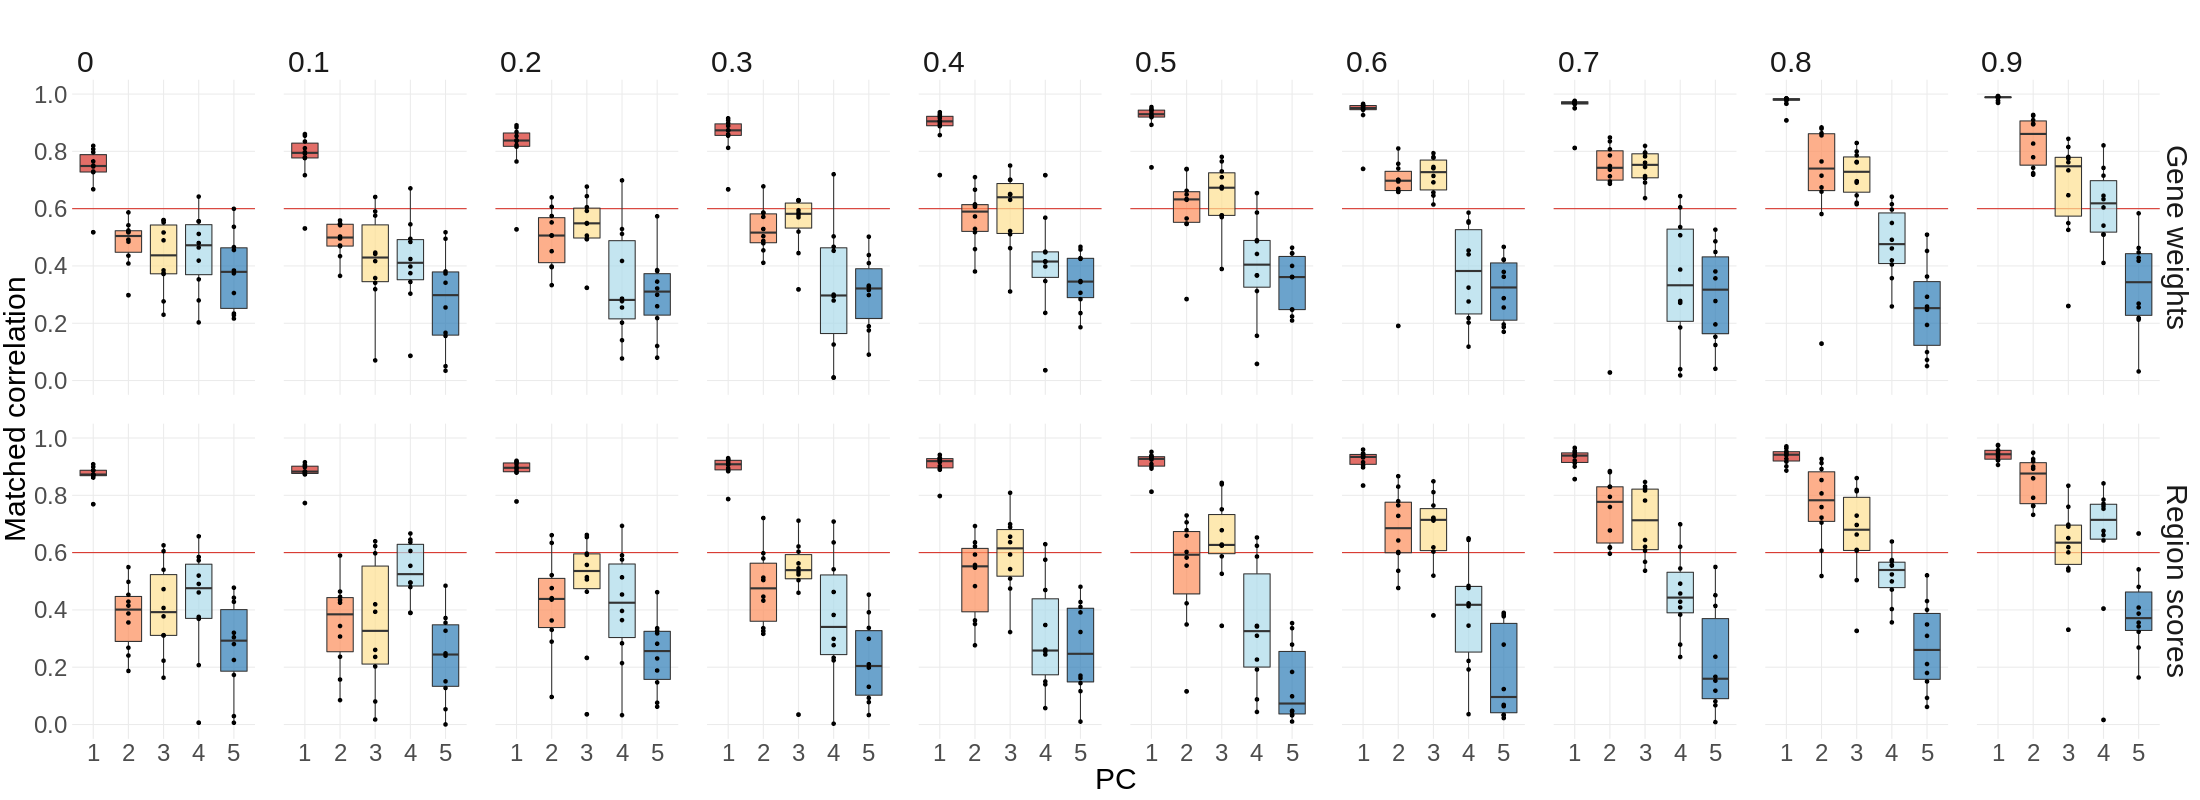

In [94]:
%%R -w 2200 -h 800 -i triplet_versions
source("../code/Rplots.R")
plot_triplets(triplet_versions) & theme(text=element_text(size=30))

Native

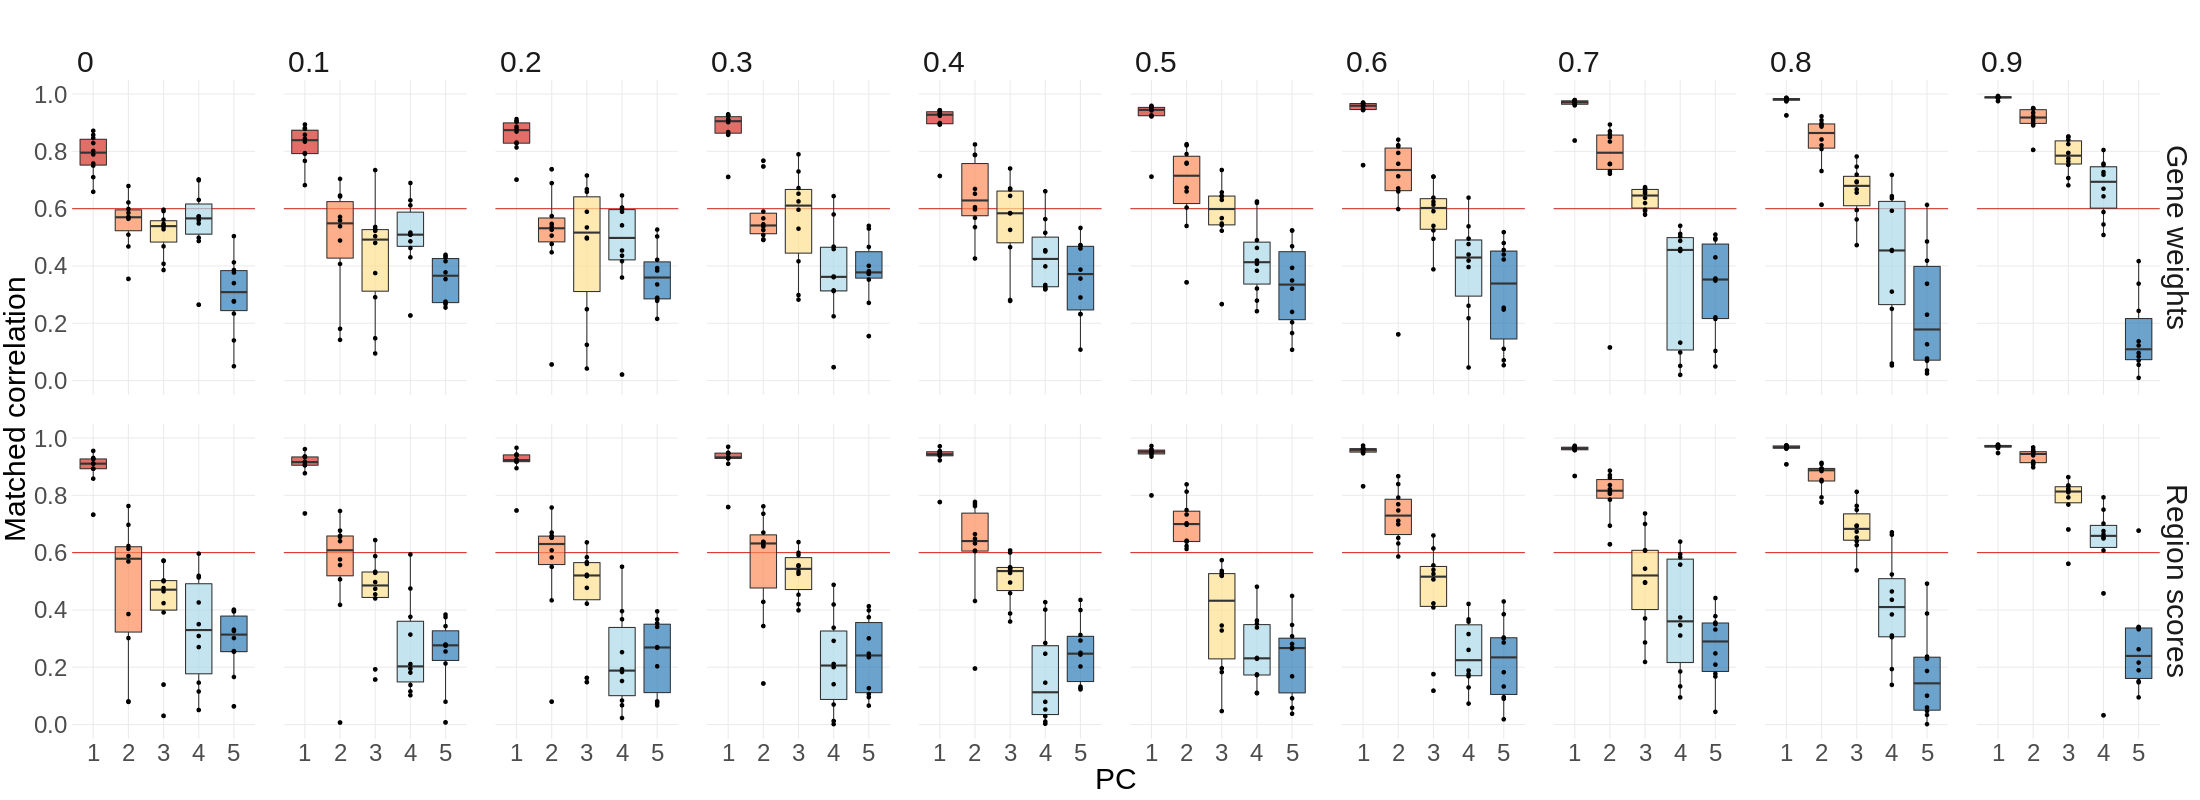

In [68]:
%%R -w 2200 -h 800 -i triplet_versions
source("../code/Rplots.R")
plot_triplets(triplet_versions) & theme(text=element_text(size=30))

Normal triplets analysis

---

# Brain genes only

In [60]:
# triplets_hcp_brain = filter_triplet_ds(triplets_hcp, only_brain=True)
# triplets_hcp_3donors_brain = filter_triplet_ds(triplets_hcp_3donors, only_brain=True)
# triplets_hcp_ds8_brain = filter_triplet_ds(triplets_hcp, ds_threshold=0.8, only_brain=True)
# triplets_hcp_3donors_ds8_brain = filter_triplet_ds(triplets_hcp_3donors, ds_threshold=0.8, only_brain=True)

coefs_dict = {
    'No filters': disjoint_corrs(triplets_hcp_brain),
    'Region filter \n(3+ donors)': disjoint_corrs(triplets_hcp_3donors_brain),
    'Gene filter \n(top 20% diff. stab.)': disjoint_corrs(triplets_hcp_ds8_brain),
    'Both region \n& gene filters': disjoint_corrs(triplets_hcp_3donors_ds8_brain),
}

scores_dict = {
    'No filters': disjoint_corrs(triplets_hcp_brain, how='scores'),
    'Region filter \n(3+ donors)': disjoint_corrs(triplets_hcp_3donors_brain, how='scores'),
    'Gene filter \n(top 20% diff. stab.)': disjoint_corrs(triplets_hcp_ds8_brain, how='scores'),
    'Both region \n& gene filters': disjoint_corrs(triplets_hcp_3donors_ds8_brain, how='scores'),
}


triplet_versions = (
    pd.concat({'Gene weights':pd.concat(coefs_dict), 'Region scores':pd.concat(scores_dict)})
    .reset_index()
    .rename(columns={'level_0':'how', 'level_1':'version', 'level_2':'component'})
    .assign(component=lambda x: x['component'].replace({i:f'{i+1}' for i in range(5)}))
    .melt(id_vars=['how', 'version', 'component'], var_name='pair', value_name='corr')
    .assign(corr_abs = lambda x: np.abs(x['corr']))
    .assign(version = lambda x: pd.Categorical(x['version'], categories=x['version'].unique(),ordered=True))
)

AttributeError: 'pcaVersion' object has no attribute 'stability'

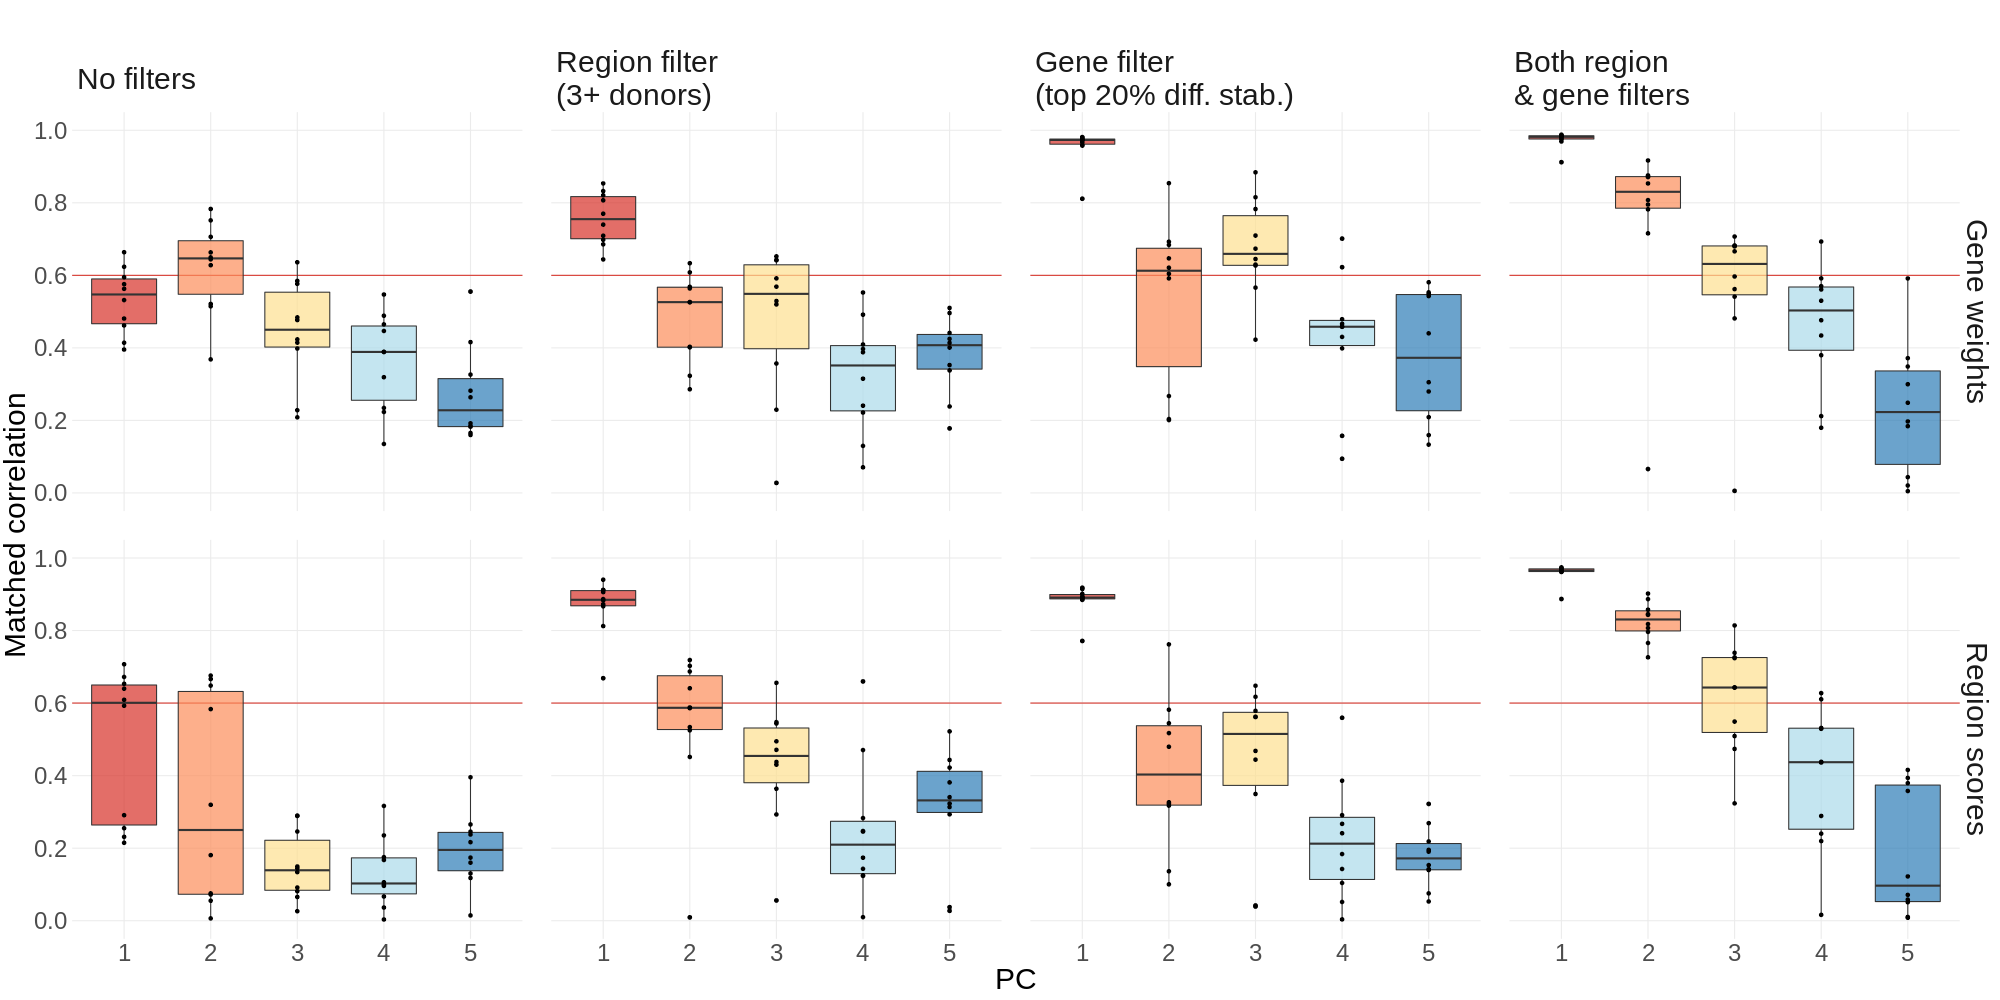

In [61]:
%%R -w 2000 -h 1000 -i triplet_versions
plot_triplets(triplet_versions) & theme(text=element_text(size=30))